## Validate Dropout implementation

In [1]:
# dependencies
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import torch.optim as optim
import time

from implementation.dropout import Dropout
from utils.tensor_loader import FastTensorDataLoader
from utils.plots import plot_dropout_histories, summarize_metrics, plot_neuron_correlations

np.random.seed(42)
torch.manual_seed(42)

## Simple Distribution Validation
Test to see if both standard and inverted dropout show expected results

In [2]:
p = 0.5
input_tensor = torch.ones(500, 500) 

# inverted
drop_inv = Dropout(p=p, mode="inverted")
drop_inv.train()
out_inv = drop_inv(input_tensor)
# 50% is dropped. The mean would be 0.5, but scaling should make it close to 1
print(f"Inverted (Train) Mean: {out_inv.mean():.4f} (Expected ~1.0)")
    
drop_inv.eval()
out_inv_eval = drop_inv(input_tensor)
print(f"Inverted (Eval)  Mean: {out_inv_eval.mean():.4f} (Expected 1.0)\n")

# standard
drop_std = Dropout(p=p, mode="standard")
drop_std.train()
out_std = drop_std(input_tensor)
print(f"Standard (Train) Mean: {out_std.mean():.4f} (Expected ~0.5)")
    
drop_std.eval()
out_std_eval = drop_std(input_tensor)
# Tensors are not dropped. The mean would be 1.0, but scaling should make it close to 0.5
print(f"Standard (Eval)  Mean: {out_std_eval.mean():.4f} (Expected 0.5)")

Inverted (Train) Mean: 1.0004 (Expected ~1.0)
Inverted (Eval)  Mean: 1.0000 (Expected 1.0)

Standard (Train) Mean: 0.5001 (Expected ~0.5)
Standard (Eval)  Mean: 0.5000 (Expected 0.5)


## Loading Fashion-MNIST

In [3]:
# import dataset
train = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)

test = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor(),
)

train[0][0].shape, train[0][1]

(torch.Size([1, 28, 28]), 9)

In [4]:
train.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

Text(0.5, 1.0, '9')

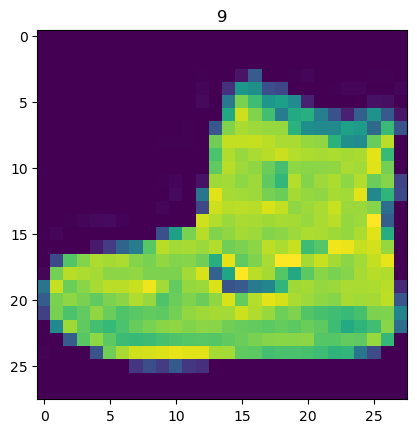

In [5]:
image, label = train[0]
plt.imshow(image.squeeze())
plt.title(label)

## Validate Dropout Using Different Models

In [6]:
# create fast dataloaders (avoid using if not enough vram)
train_loader = FastTensorDataLoader(train, shuffle=True)
test_loader = FastTensorDataLoader(test, shuffle=False)

In [7]:
from nn_models.simple import SimpleDropoutNetwork, SimpleDropoutNetworkSingle
from nn_models.lenet import DropoutLeNet
from nn_models.vgg import DropoutVGG
from utils.validate import train_and_validate

device = 'cuda' if torch.cuda.is_available() else 'cpu'

dropout_models = [
    SimpleDropoutNetwork,
    DropoutLeNet,
    DropoutVGG
]

dropout_rates = [0.0, 0.2, 0.4, 0.6, 0.8]

results = {}
saved_models = {}

for dropout_model in dropout_models:
    for p in dropout_rates:
        print(f"\nTesting Dropout p={p}")
        model = dropout_model(dropout_rate=p, dropout_mode="standard", input_channels=1, img_size=28).to(device)
        history = train_and_validate(model, train_loader, test_loader, epochs=60, max_norm=3.0) #TODO: testar outros valores max_norm? (ex: None, 4.0)
        try:
            results[model.name][p] = history
            saved_models[model.name][p] = model
        except:
            results[model.name] = {}
            results[model.name][p] = history
            saved_models[model.name] = {}
            saved_models[model.name][p] = model
        


Testing Dropout p=0.0


Training model 'Simple Dropout Neural Network': 100%|██████████| 60/60 [00:05<00:00, 10.06it/s]


Finished in 5.97s

Testing Dropout p=0.2


Training model 'Simple Dropout Neural Network': 100%|██████████| 60/60 [00:06<00:00,  9.65it/s]


Finished in 6.22s

Testing Dropout p=0.4


Training model 'Simple Dropout Neural Network': 100%|██████████| 60/60 [00:06<00:00,  9.69it/s]


Finished in 6.19s

Testing Dropout p=0.6


Training model 'Simple Dropout Neural Network': 100%|██████████| 60/60 [00:06<00:00,  9.78it/s]


Finished in 6.14s

Testing Dropout p=0.8


Training model 'Simple Dropout Neural Network': 100%|██████████| 60/60 [00:06<00:00,  9.32it/s]


Finished in 6.44s

Testing Dropout p=0.0


Training model 'LeNet Dropout Neural Network': 100%|██████████| 60/60 [00:12<00:00,  4.79it/s]


Finished in 12.52s

Testing Dropout p=0.2


Training model 'LeNet Dropout Neural Network': 100%|██████████| 60/60 [00:15<00:00,  3.85it/s]


Finished in 15.59s

Testing Dropout p=0.4


Training model 'LeNet Dropout Neural Network': 100%|██████████| 60/60 [00:21<00:00,  2.85it/s]


Finished in 21.09s

Testing Dropout p=0.6


Training model 'LeNet Dropout Neural Network': 100%|██████████| 60/60 [00:24<00:00,  2.42it/s]


Finished in 24.79s

Testing Dropout p=0.8


Training model 'LeNet Dropout Neural Network': 100%|██████████| 60/60 [00:25<00:00,  2.33it/s]


Finished in 25.77s

Testing Dropout p=0.0


Training model 'VGG Dropout Neural Network': 100%|██████████| 60/60 [08:30<00:00,  8.50s/it]


Finished in 510.07s

Testing Dropout p=0.2


Training model 'VGG Dropout Neural Network': 100%|██████████| 60/60 [08:26<00:00,  8.43s/it]


Finished in 506.07s

Testing Dropout p=0.4


Training model 'VGG Dropout Neural Network': 100%|██████████| 60/60 [08:22<00:00,  8.38s/it]


Finished in 502.76s

Testing Dropout p=0.6


Training model 'VGG Dropout Neural Network': 100%|██████████| 60/60 [08:22<00:00,  8.38s/it]


Finished in 502.95s

Testing Dropout p=0.8


Training model 'VGG Dropout Neural Network': 100%|██████████| 60/60 [08:23<00:00,  8.40s/it]

Finished in 503.74s


In [8]:
summarize_metrics(results)

Model  Dropout Rate  Test Acc (%)  F1 Score  \
5    LeNet Dropout Neural Network        0.0000       89.8400    0.8972   
6    LeNet Dropout Neural Network        0.2000       90.2100    0.9013   
7    LeNet Dropout Neural Network        0.4000       89.7700    0.8973   
8    LeNet Dropout Neural Network        0.6000       87.4600    0.8732   
9    LeNet Dropout Neural Network        0.8000       80.3100    0.7756   
0   Simple Dropout Neural Network        0.0000       89.2800    0.8934   
1   Simple Dropout Neural Network        0.2000       89.5600    0.8946   
2   Simple Dropout Neural Network        0.4000       89.6200    0.8958   
3   Simple Dropout Neural Network        0.6000       89.3100    0.8923   
4   Simple Dropout Neural Network        0.8000       87.4600    0.8740   
10     VGG Dropout Neural Network        0.0000       93.3900    0.9338   
11     VGG Dropout Neural Network        0.2000       92.2700    0.9215   
12     VGG Dropout Neural Network        0.4000       92.8900    0.9298   
13     VGG Dropout Neural Network        0.6000       92.9600    0.9295   
14     VGG Dropout Neural Network        0.8000       92.6300    0.9265   

    Test Loss  
5      0.2902  
6      0.2753  
7      0.2799  
8      0.3458  
9      0.5460  
0      0.4201  
1      0.3680  
2      0.3185  
3      0.3085  
4      0.3523  
10     0.5263  
11     0.4591  
12     0.4263  
13     0.4402  
14     0.4333

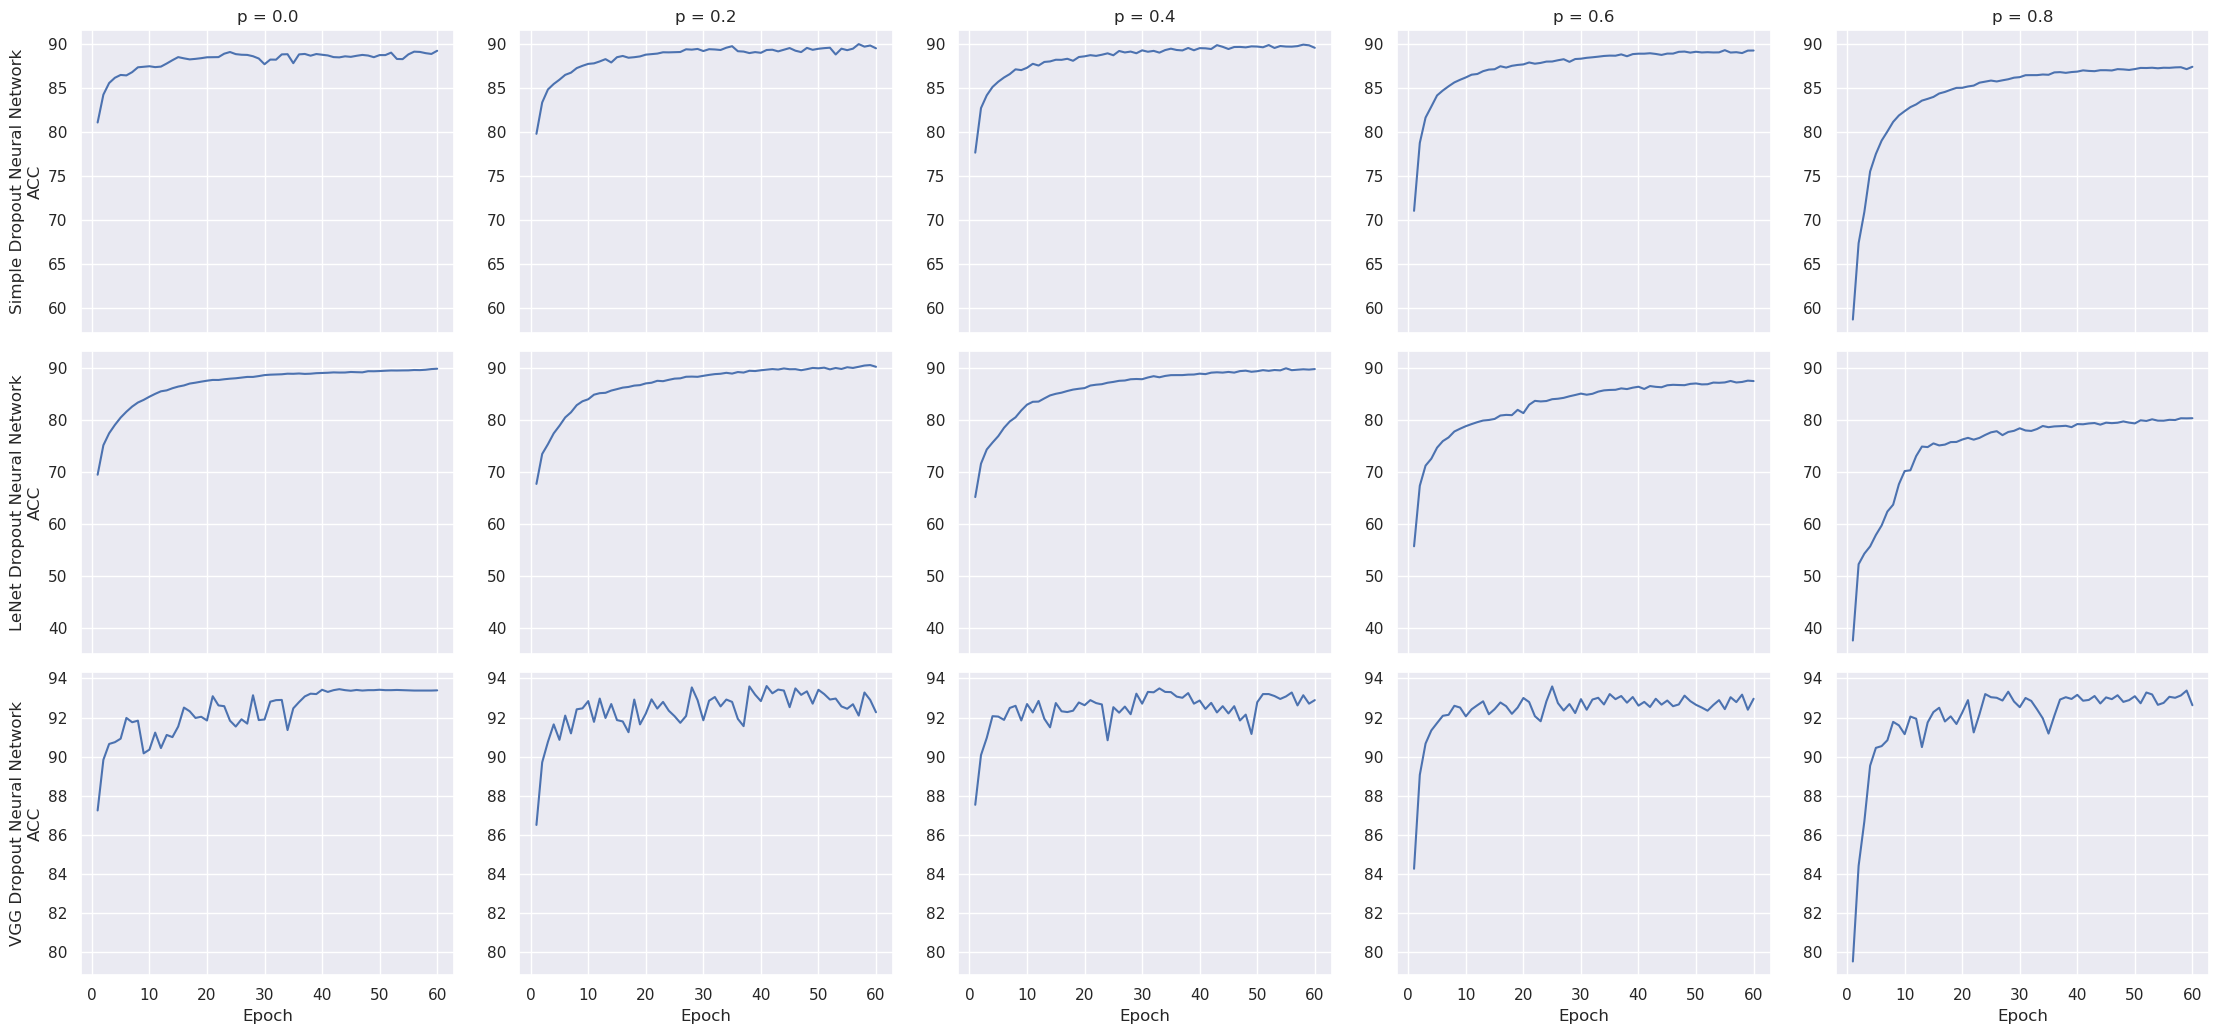

In [9]:
plot_dropout_histories(results, metric="acc")

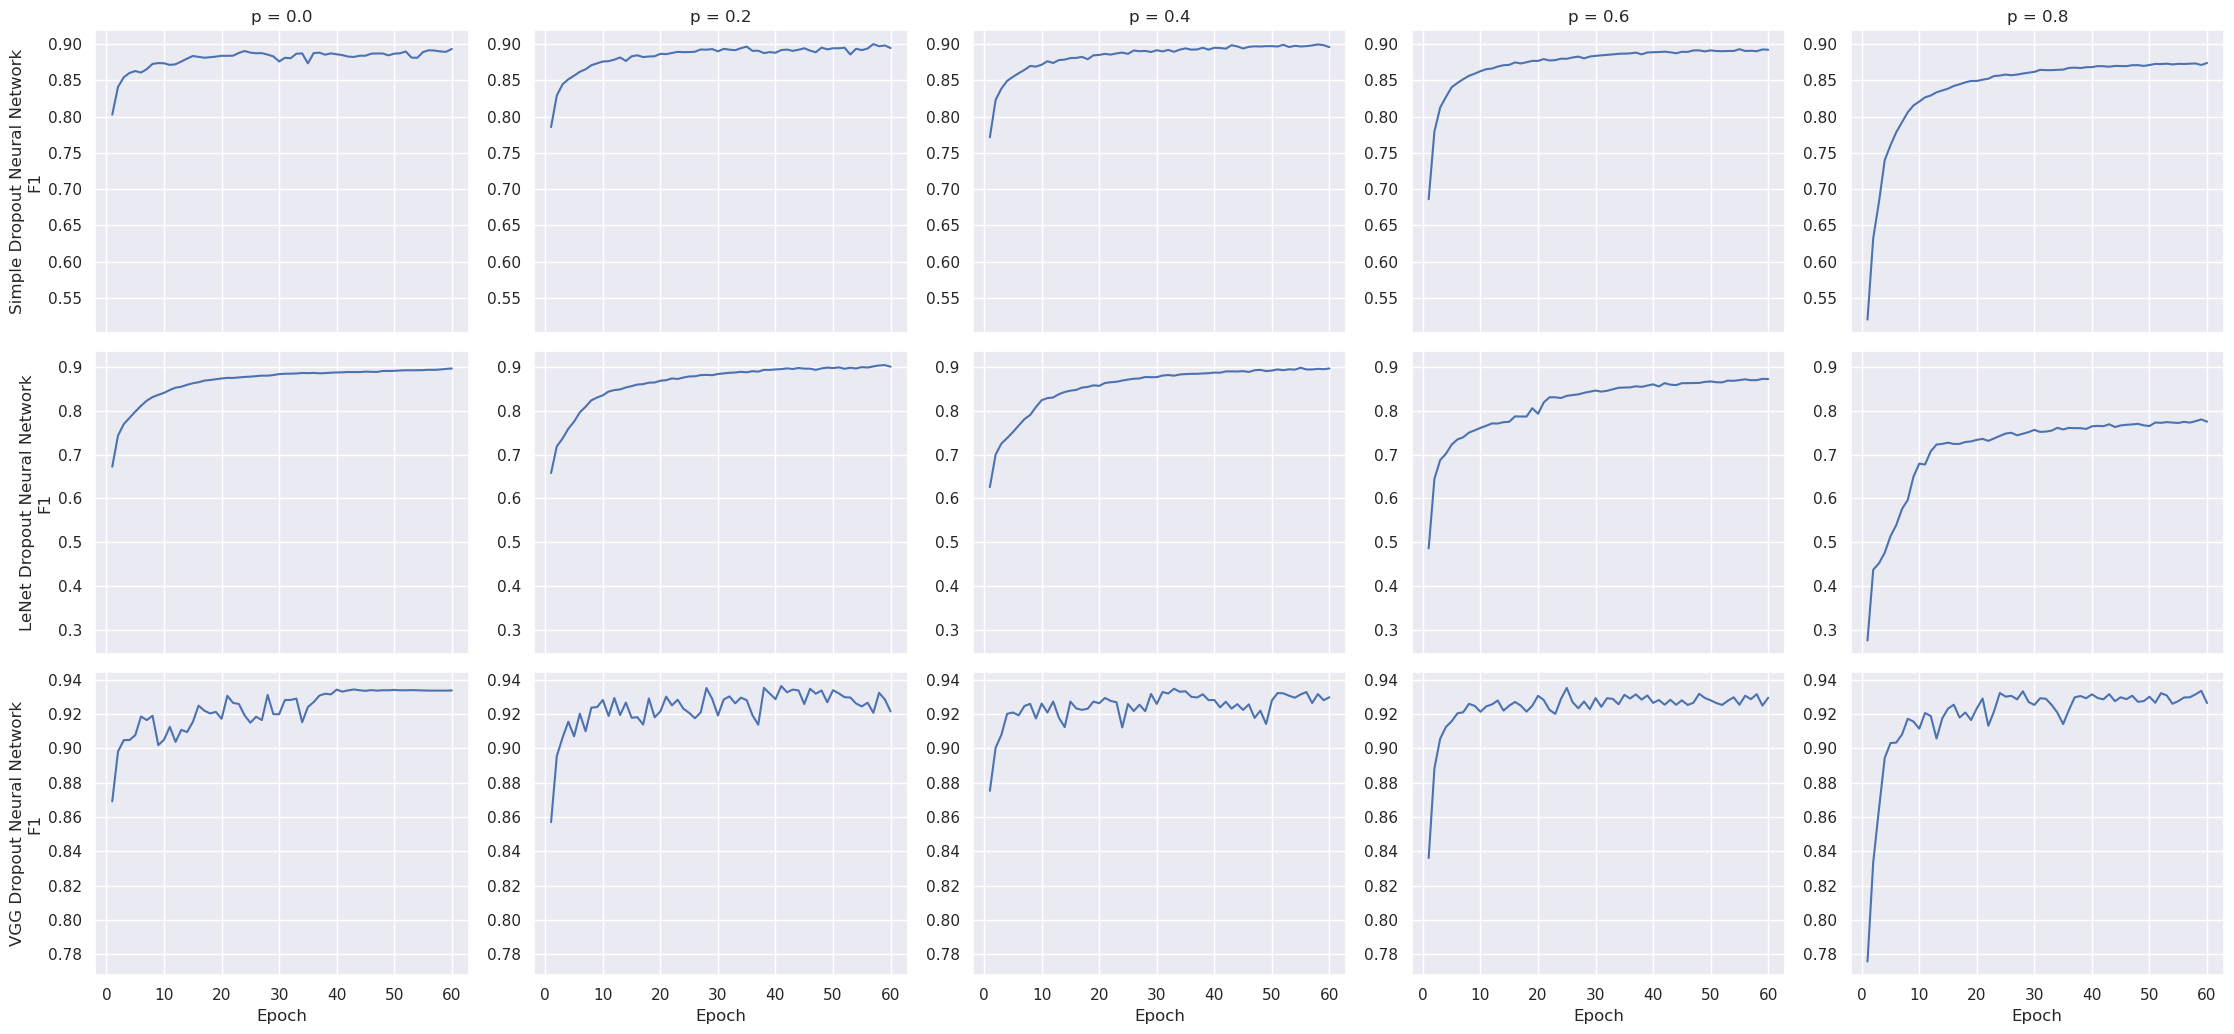

In [10]:
plot_dropout_histories(results, metric="f1")

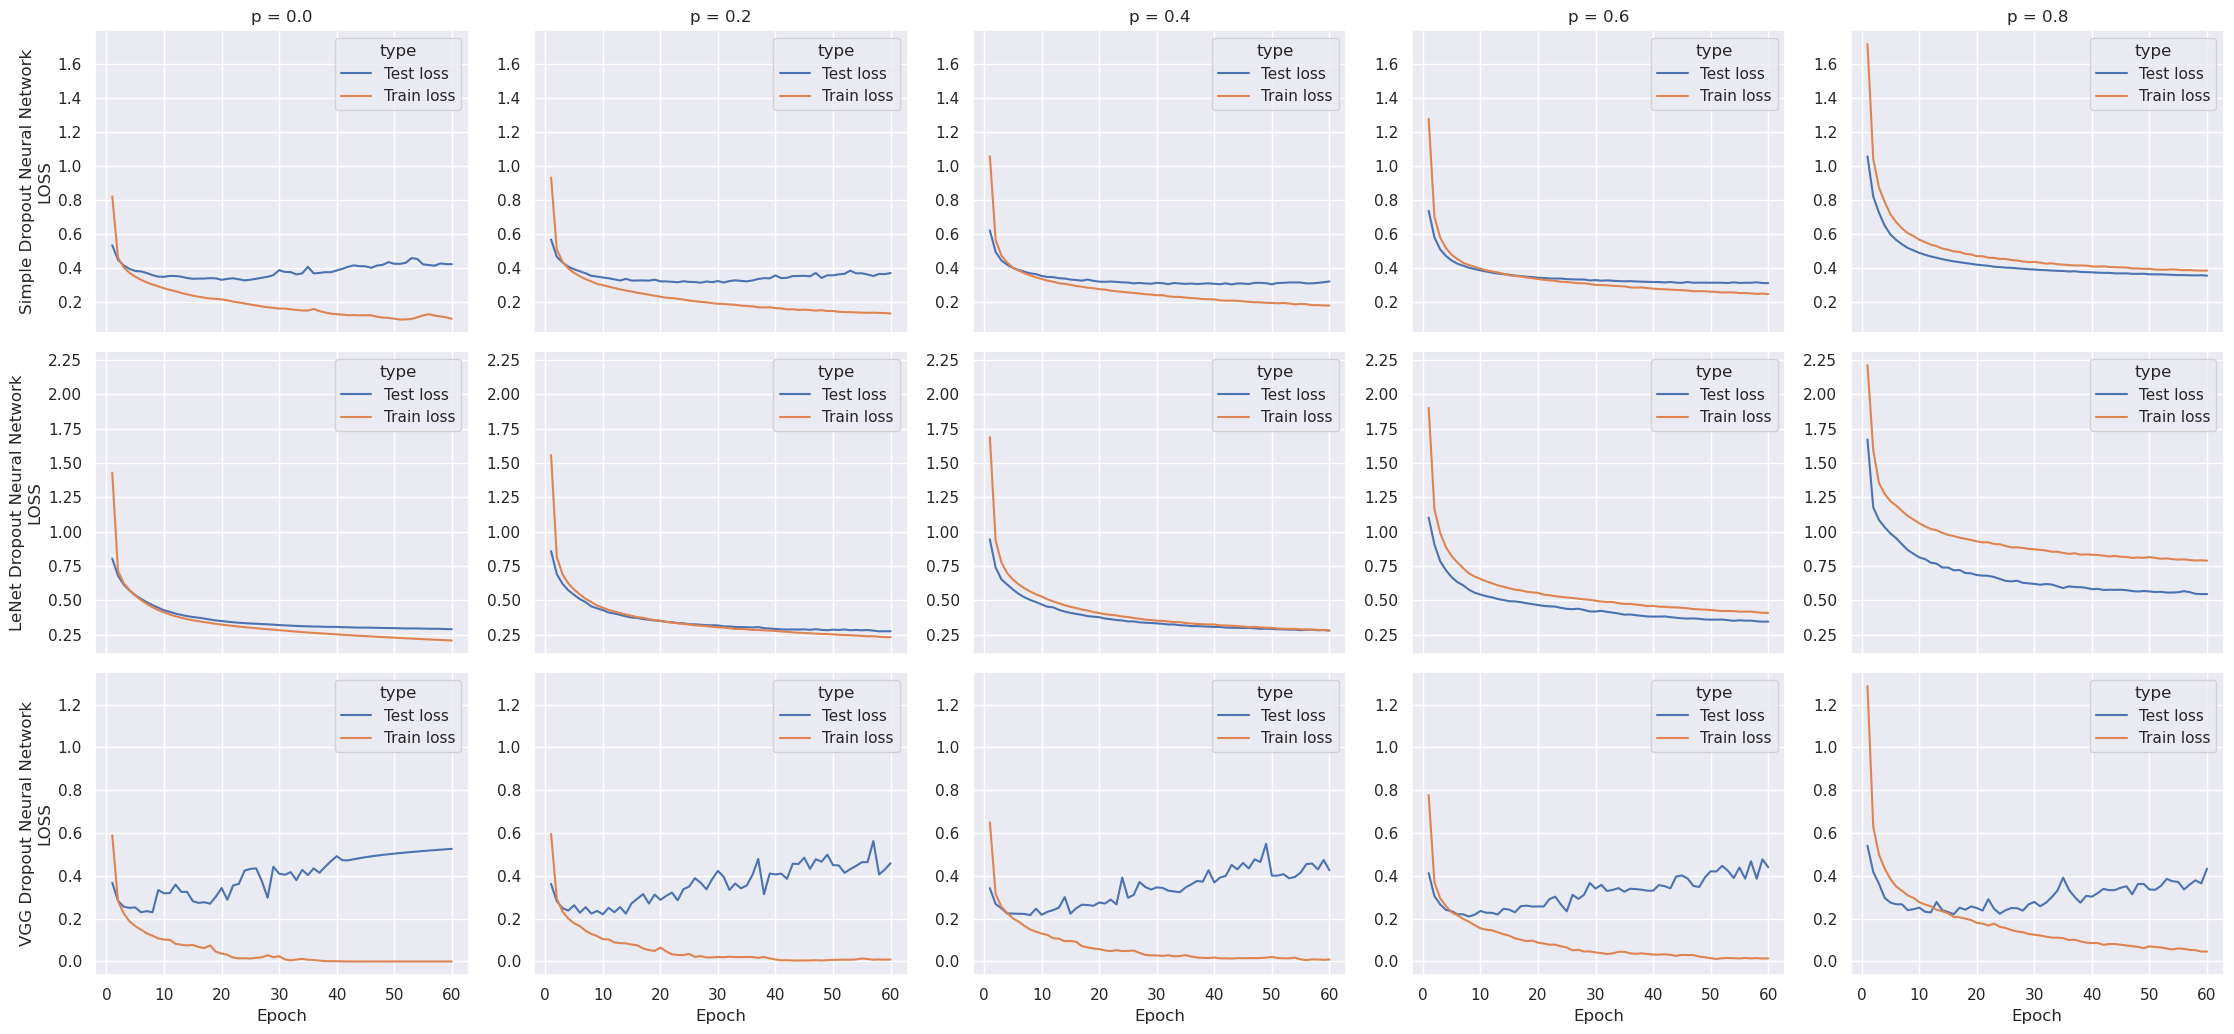

In [11]:
plot_dropout_histories(results, metric="loss")

## Verificando Correlação de Neurônios

/home/paulofr/miniforge3/envs/DROPOUT/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/paulofr/miniforge3/envs/DROPOUT/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/paulofr/miniforge3/envs/DROPOUT/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/paulofr/miniforge3/envs/DROPOUT/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/paulofr/miniforge3/envs/DROPOUT/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/paulofr/miniforge3/envs/DROPOUT/lib/python3.10/site-packages/numpy/lib/_function_base_imp

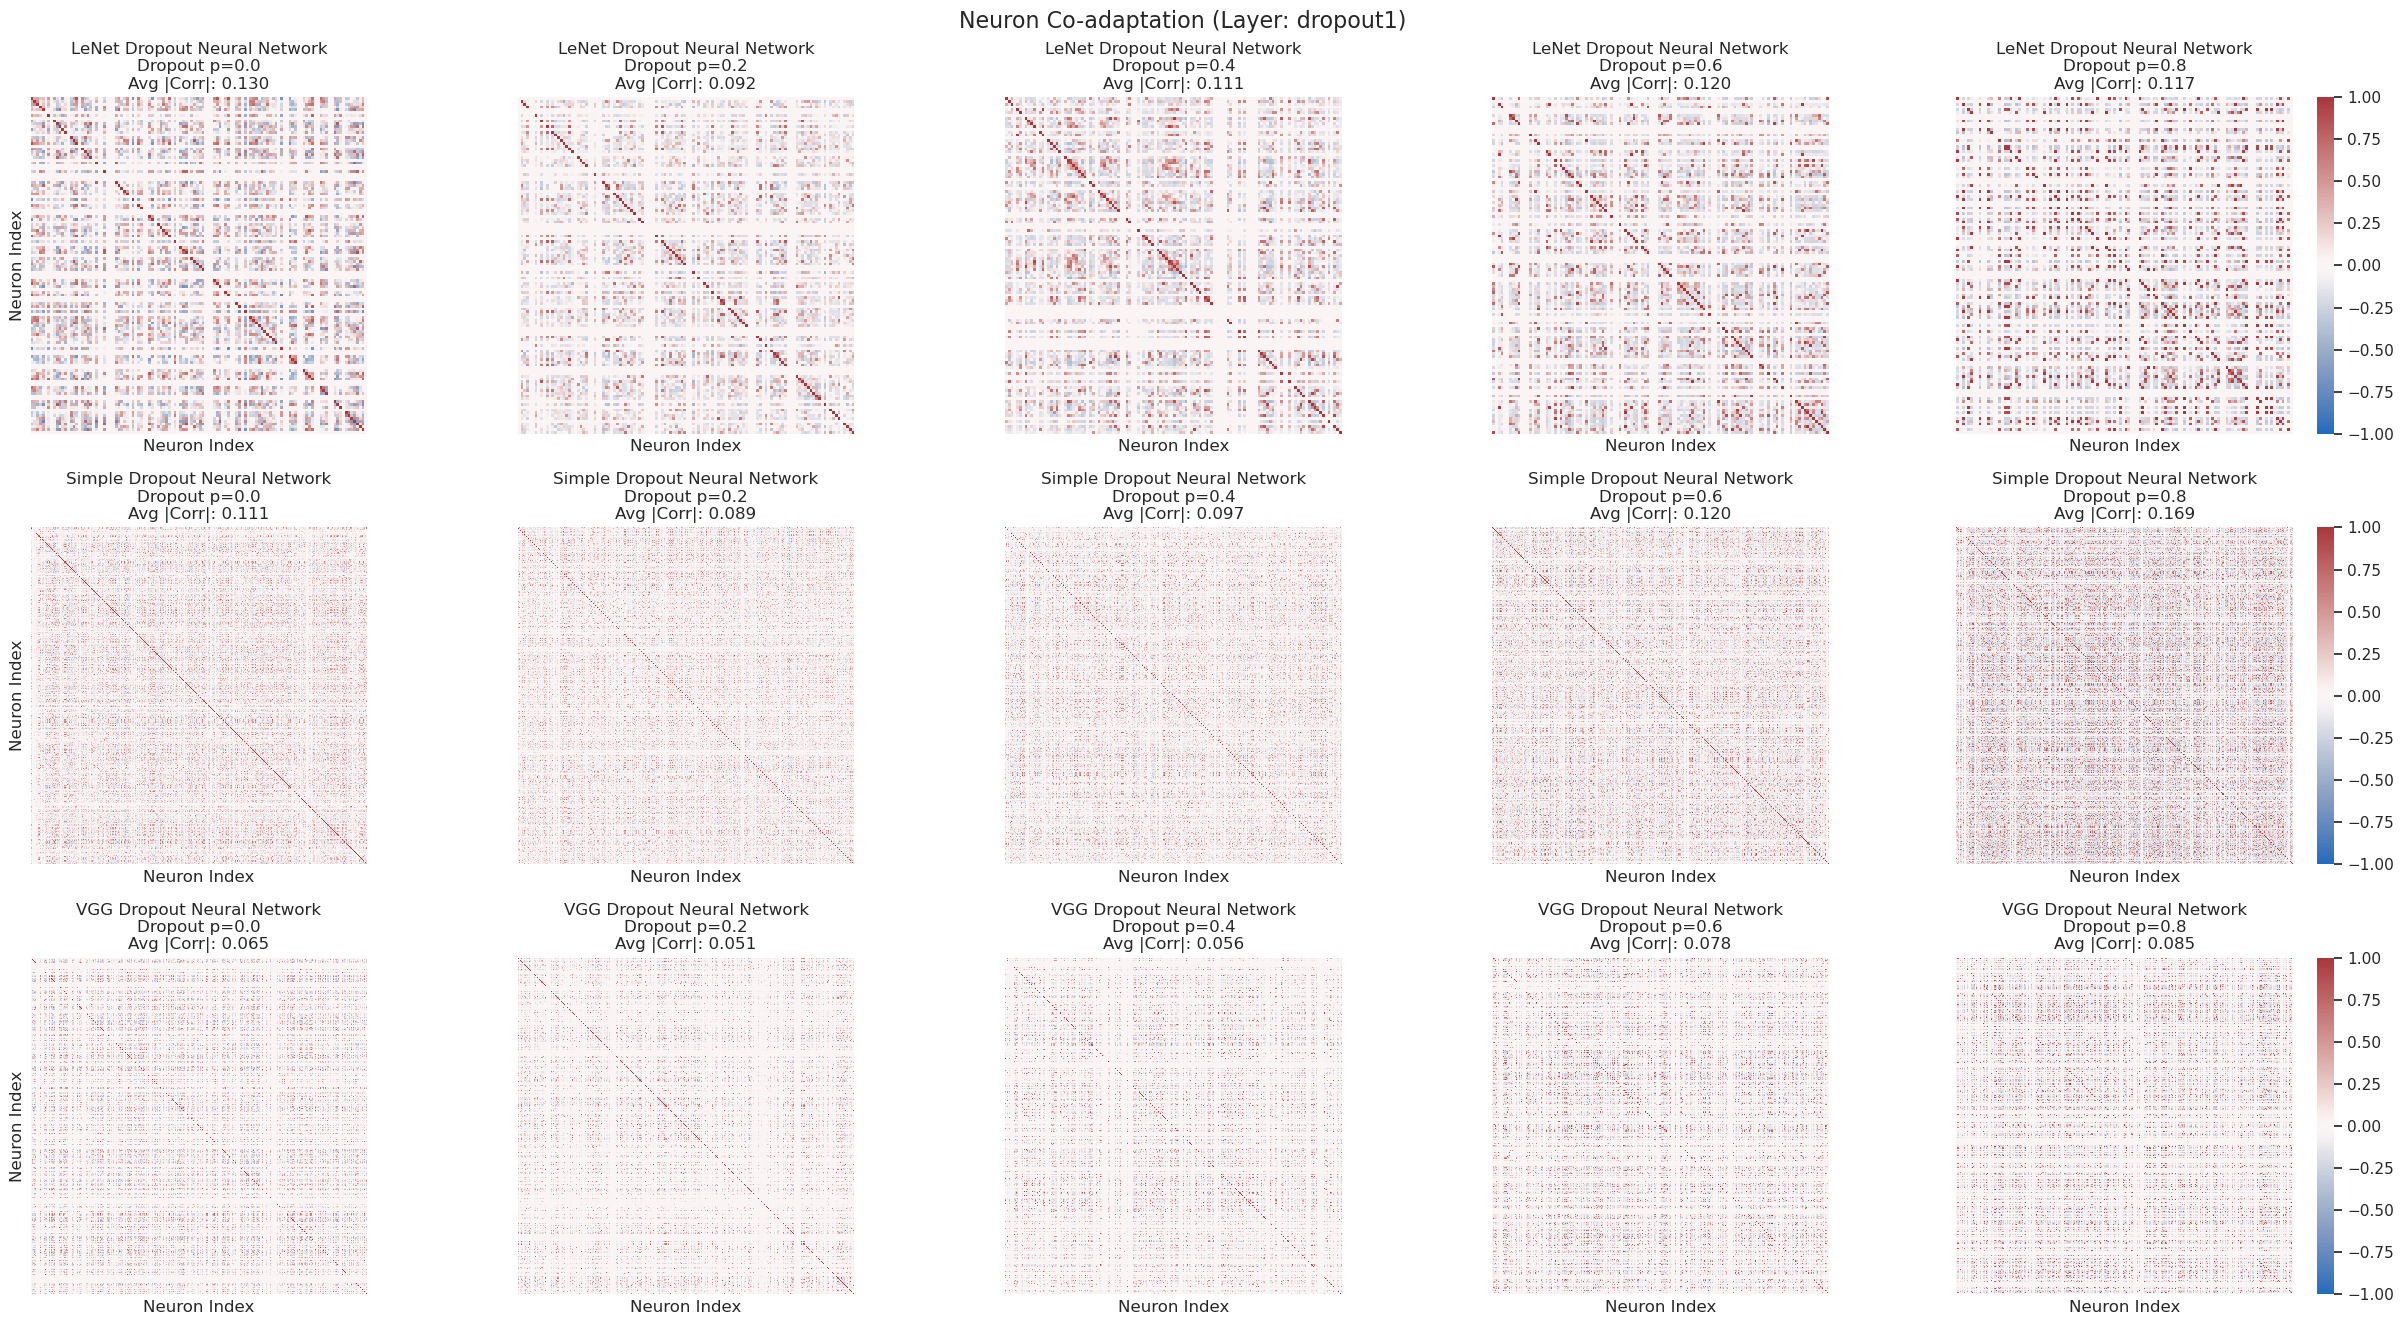

In [12]:
plot_neuron_correlations(saved_models, test_loader, layer_name='dropout1', device=device)

#### Pelas matrizes de correlação, vemos que dropout de 0.2 gerou resultados mais interessantes. É possível que dropout muito grande ative um "Modo Sobrevivência" das informações mais importantes garantindo que sejam repassadas por meio da maior redundância quando a dimensão de compressão é pequena demais para o problema

/home/paulofr/miniforge3/envs/DROPOUT/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/paulofr/miniforge3/envs/DROPOUT/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/paulofr/miniforge3/envs/DROPOUT/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/paulofr/miniforge3/envs/DROPOUT/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/paulofr/miniforge3/envs/DROPOUT/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/paulofr/miniforge3/envs/DROPOUT/lib/python3.10/site-packages/numpy/lib/_function_base_imp

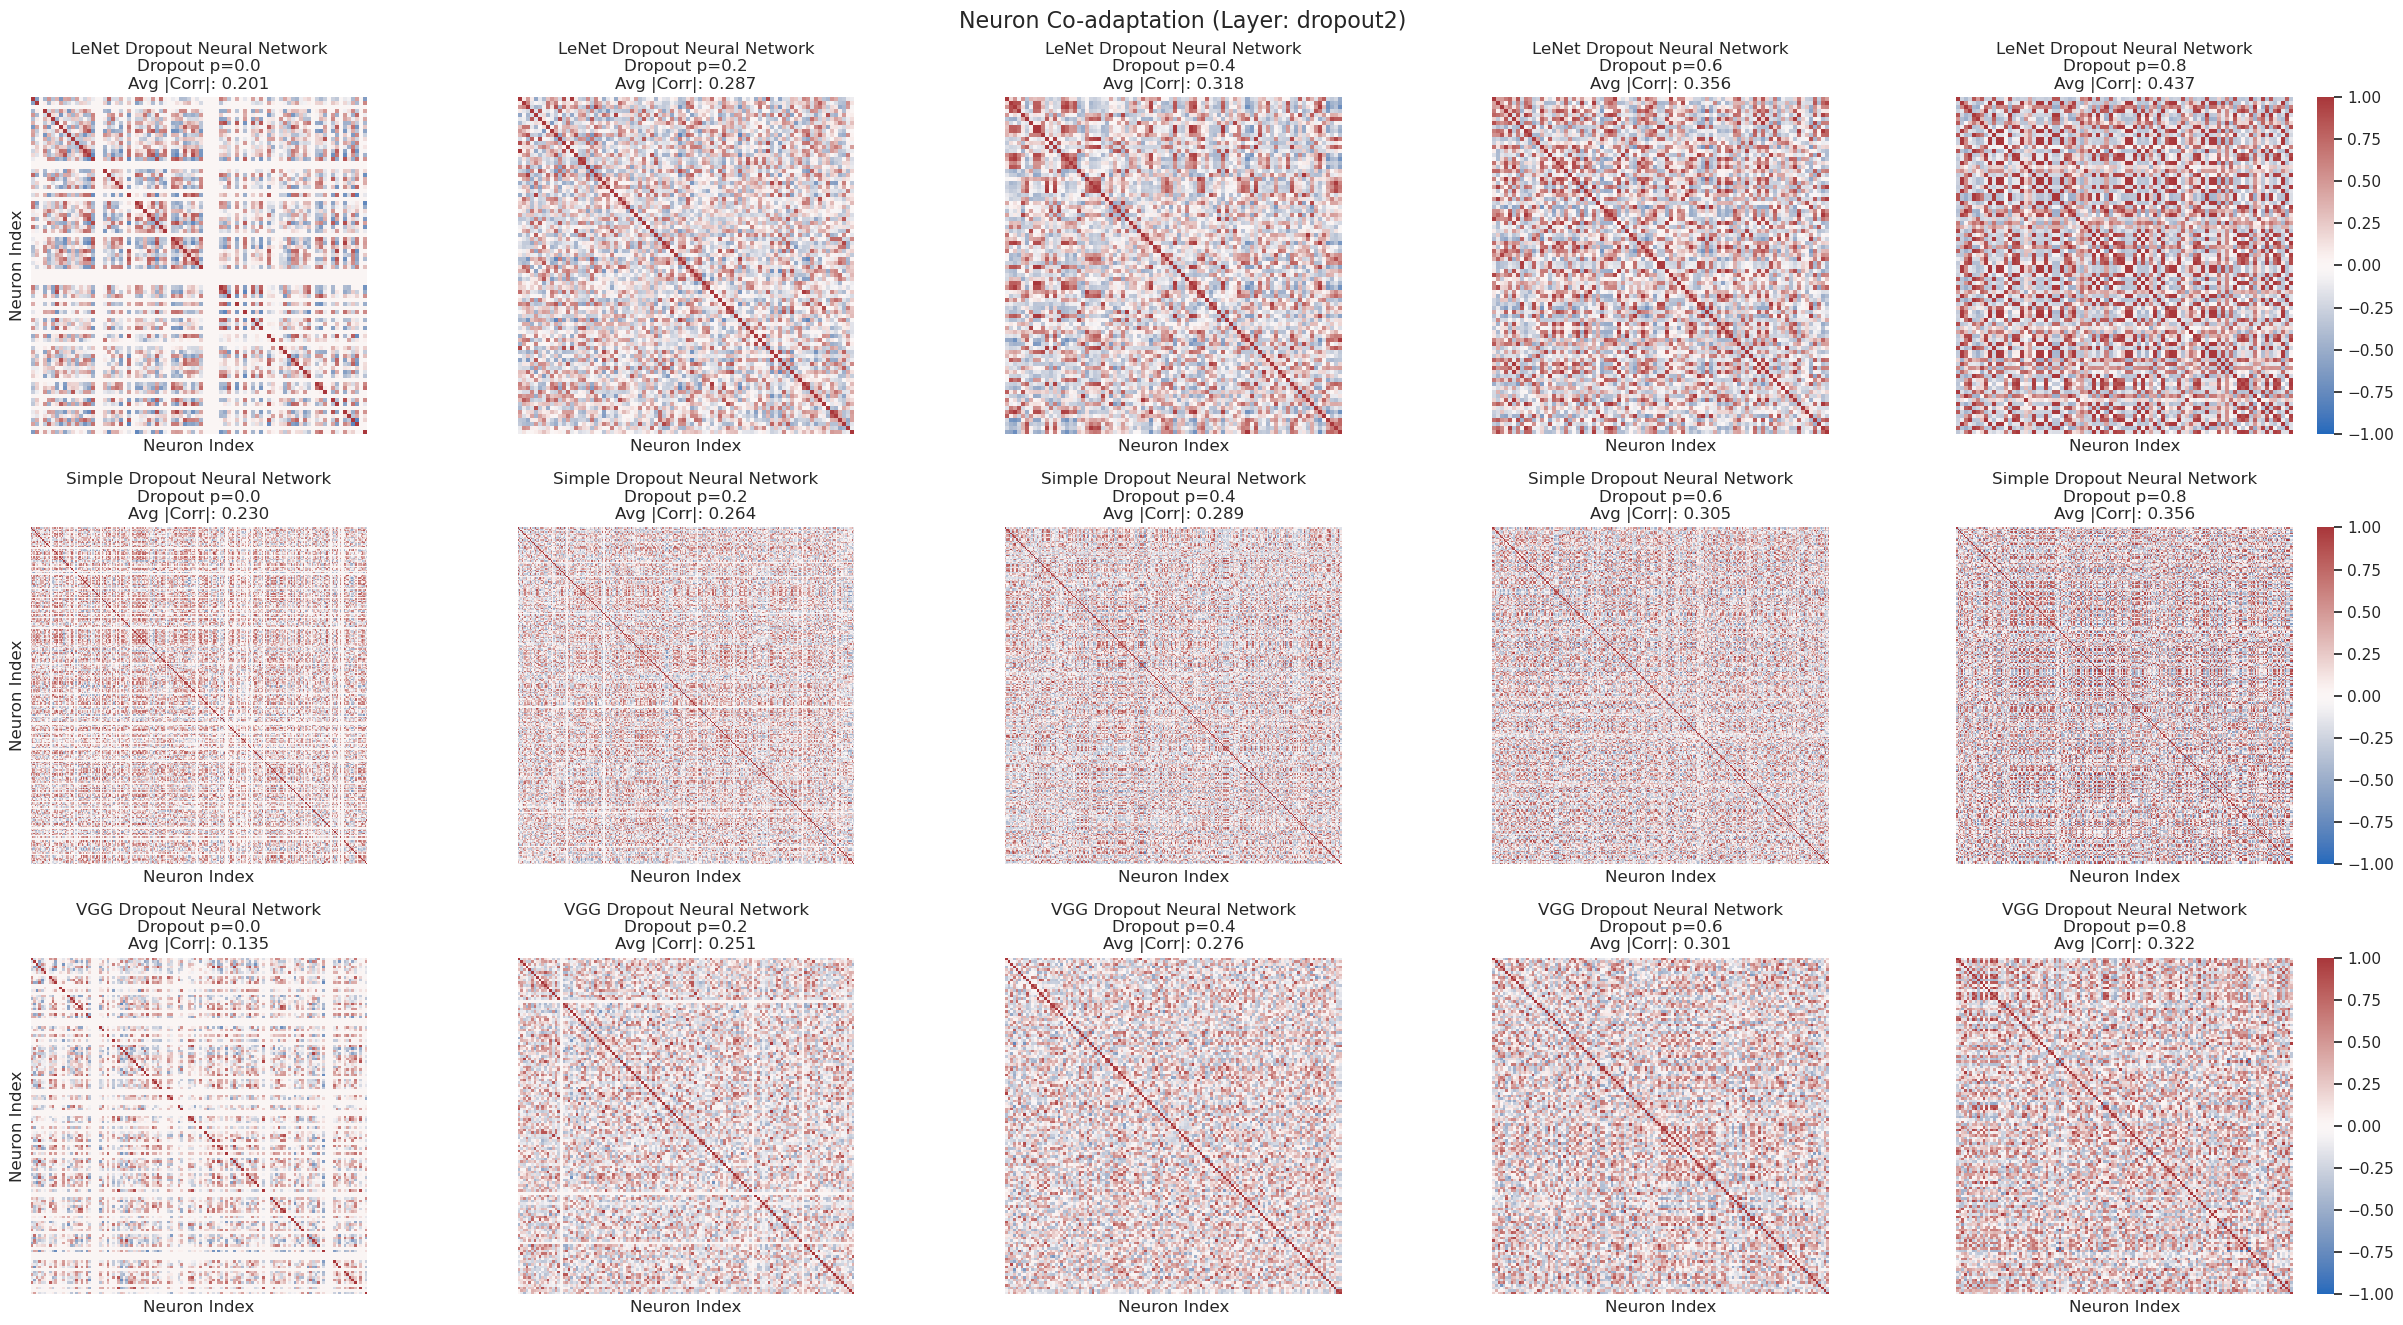

In [13]:
plot_neuron_correlations(saved_models, test_loader, layer_name='dropout2', device=device)

#### A segunda camada de dropout é mais profunda e nas redes escolhidas consiste em compressão dos dados. Pode ser que para o problema certas informações essenciais precisem ser passadas e a dimensão reduzida gere pressão para manter essas informações. Reduzir ainda mais os neurônios pode ativar o "Modo Sobrevivência" dessas informações que podem ser perdidas

In [14]:
correlation_results = {}
correlation_saved_models = {}
    
for p in dropout_rates:
    print(f"\nTesting Dropout p={p}")
    model = SimpleDropoutNetworkSingle(dropout_rate=p, dropout_mode="standard", input_channels=1, img_size=28).to(device)
    history = train_and_validate(model, train_loader, test_loader, epochs=60, max_norm=3.0)
    try:
        correlation_results[model.name][p] = history
        correlation_saved_models[model.name][p] = model
    except:
        correlation_results[model.name] = {}
        correlation_results[model.name][p] = history
        correlation_saved_models[model.name] = {}
        correlation_saved_models[model.name][p] = model
        


Testing Dropout p=0.0


Training model 'Single Dropout Neural Network': 100%|██████████| 60/60 [00:12<00:00,  4.87it/s]


Finished in 12.33s

Testing Dropout p=0.2


Training model 'Single Dropout Neural Network': 100%|██████████| 60/60 [00:12<00:00,  4.78it/s]


Finished in 12.55s

Testing Dropout p=0.4


Training model 'Single Dropout Neural Network': 100%|██████████| 60/60 [00:12<00:00,  4.80it/s]


Finished in 12.50s

Testing Dropout p=0.6


Training model 'Single Dropout Neural Network': 100%|██████████| 60/60 [00:12<00:00,  4.80it/s]


Finished in 12.50s

Testing Dropout p=0.8


Training model 'Single Dropout Neural Network': 100%|██████████| 60/60 [00:12<00:00,  4.77it/s]

Finished in 12.57s


In [15]:
summarize_metrics(correlation_results)

Model  Dropout Rate  Test Acc (%)  F1 Score  \
0  Single Dropout Neural Network        0.0000       88.8700    0.8867   
1  Single Dropout Neural Network        0.2000       89.7900    0.8969   
2  Single Dropout Neural Network        0.4000       89.8400    0.8971   
3  Single Dropout Neural Network        0.6000       89.7100    0.8963   
4  Single Dropout Neural Network        0.8000       88.7400    0.8868   

   Test Loss  
0     0.4746  
1     0.3737  
2     0.3298  
3     0.3055  
4     0.3168

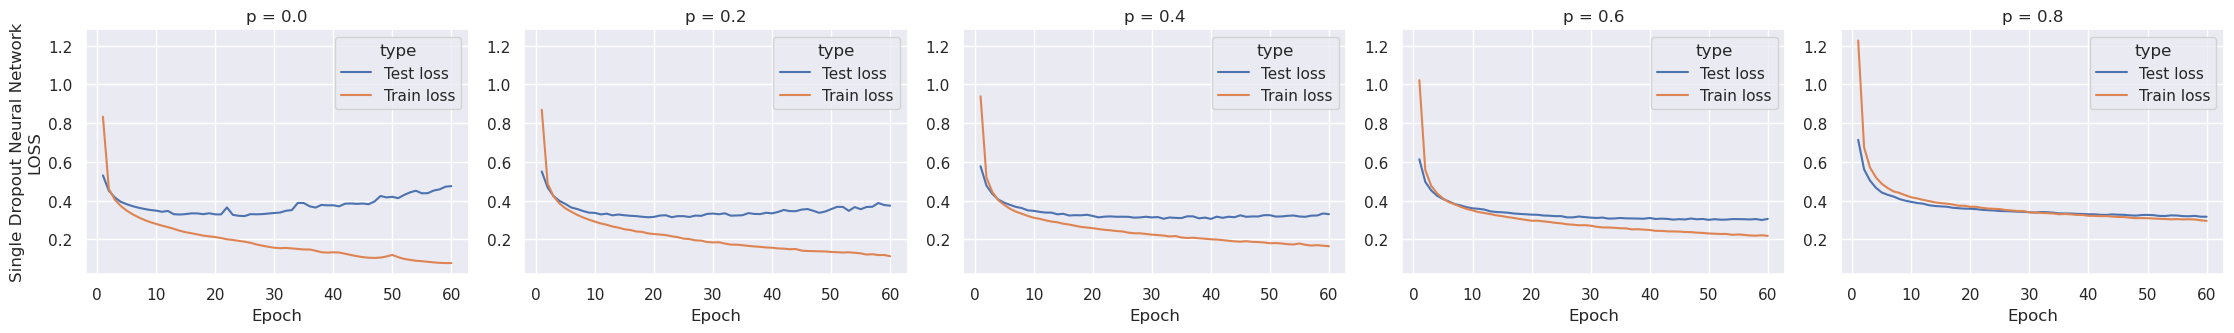

In [16]:
plot_dropout_histories(correlation_results, metric="loss")

/home/paulofr/miniforge3/envs/DROPOUT/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/paulofr/miniforge3/envs/DROPOUT/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/paulofr/miniforge3/envs/DROPOUT/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/paulofr/miniforge3/envs/DROPOUT/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/paulofr/miniforge3/envs/DROPOUT/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/paulofr/miniforge3/envs/DROPOUT/lib/python3.10/site-packages/numpy/lib/_function_base_imp

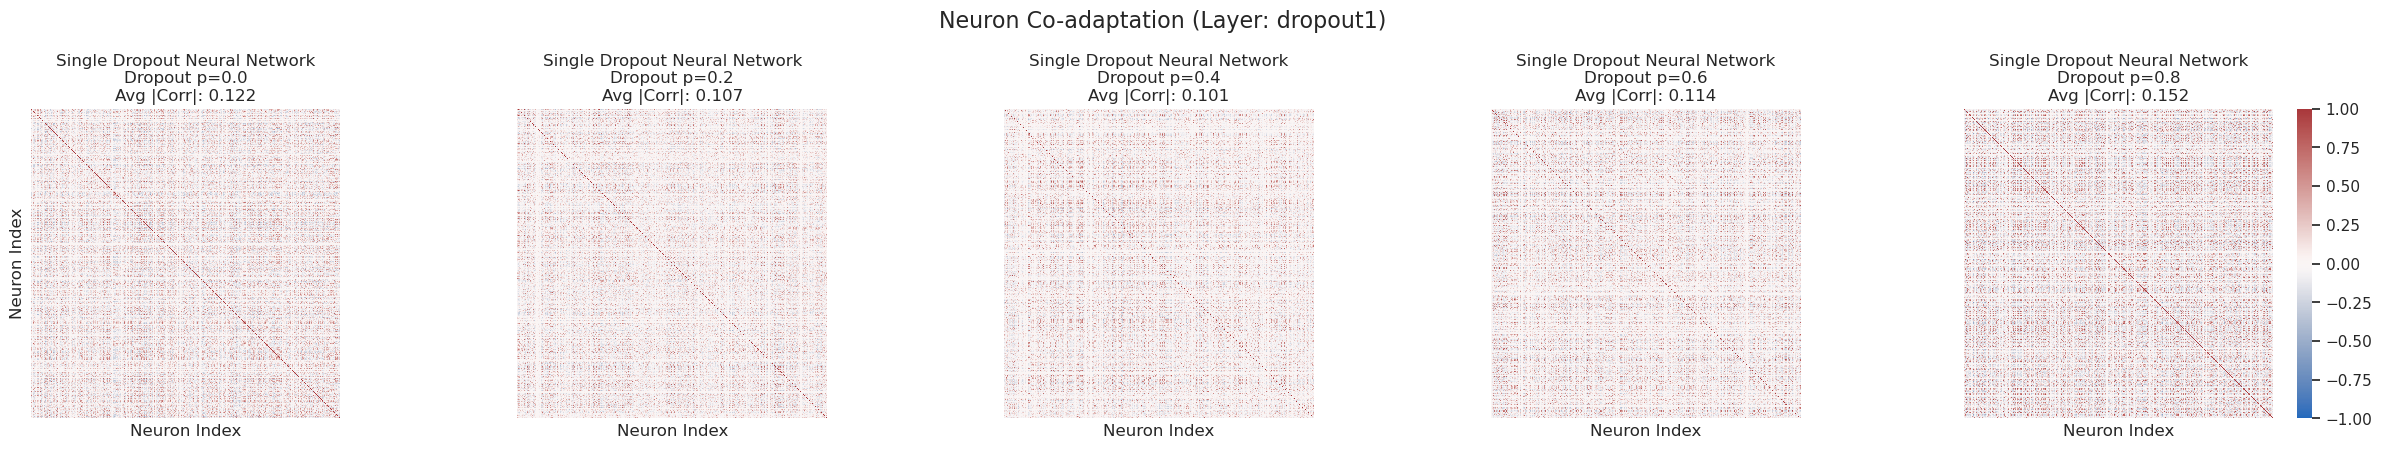

In [17]:
plot_neuron_correlations(correlation_saved_models, test_loader, layer_name='dropout1', device=device)

## Training with Subset

In [18]:
len(train)

60000

In [19]:
indices = np.random.choice(len(train), size=1000, replace=False)
train_subset = Subset(train, indices)

train_loader_small = FastTensorDataLoader(train_subset, shuffle=True, batch_size=4096)

In [20]:
results_small = {}

for dropout_model in dropout_models:
    for p in dropout_rates:
        print(f"\nTesting Dropout p={p}")
        model = dropout_model(dropout_rate=p, dropout_mode="inverted", input_channels=1, img_size=28).to(device)
        history = train_and_validate(model, train_loader_small, test_loader, epochs=60, max_norm=3.0)
        try:
            results_small[model.name][p] = history
        except:
            results_small[model.name] = {}
            results_small[model.name][p] = history


Testing Dropout p=0.0


Training model 'Simple Dropout Neural Network': 100%|██████████| 60/60 [00:02<00:00, 20.30it/s]


Finished in 2.96s

Testing Dropout p=0.2


Training model 'Simple Dropout Neural Network': 100%|██████████| 60/60 [00:02<00:00, 20.31it/s]


Finished in 2.96s

Testing Dropout p=0.4


Training model 'Simple Dropout Neural Network': 100%|██████████| 60/60 [00:02<00:00, 20.33it/s]


Finished in 2.95s

Testing Dropout p=0.6


Training model 'Simple Dropout Neural Network': 100%|██████████| 60/60 [00:02<00:00, 20.09it/s]


Finished in 2.99s

Testing Dropout p=0.8


Training model 'Simple Dropout Neural Network': 100%|██████████| 60/60 [00:02<00:00, 20.36it/s]


Finished in 2.95s

Testing Dropout p=0.0


Training model 'LeNet Dropout Neural Network': 100%|██████████| 60/60 [00:03<00:00, 18.12it/s]


Finished in 3.31s

Testing Dropout p=0.2


Training model 'LeNet Dropout Neural Network': 100%|██████████| 60/60 [00:03<00:00, 17.54it/s]


Finished in 3.42s

Testing Dropout p=0.4


Training model 'LeNet Dropout Neural Network': 100%|██████████| 60/60 [00:03<00:00, 17.46it/s]


Finished in 3.44s

Testing Dropout p=0.6


Training model 'LeNet Dropout Neural Network': 100%|██████████| 60/60 [00:03<00:00, 17.62it/s]


Finished in 3.41s

Testing Dropout p=0.8


Training model 'LeNet Dropout Neural Network': 100%|██████████| 60/60 [00:03<00:00, 17.34it/s]


Finished in 3.46s

Testing Dropout p=0.0


Training model 'VGG Dropout Neural Network': 100%|██████████| 60/60 [00:32<00:00,  1.84it/s]


Finished in 32.53s

Testing Dropout p=0.2


Training model 'VGG Dropout Neural Network': 100%|██████████| 60/60 [00:32<00:00,  1.84it/s]


Finished in 32.57s

Testing Dropout p=0.4


Training model 'VGG Dropout Neural Network': 100%|██████████| 60/60 [00:32<00:00,  1.84it/s]


Finished in 32.55s

Testing Dropout p=0.6


Training model 'VGG Dropout Neural Network': 100%|██████████| 60/60 [00:32<00:00,  1.84it/s]


Finished in 32.56s

Testing Dropout p=0.8


Training model 'VGG Dropout Neural Network': 100%|██████████| 60/60 [00:32<00:00,  1.84it/s]

Finished in 32.56s


In [21]:
summarize_metrics(results_small)

Model  Dropout Rate  Test Acc (%)  F1 Score  \
5    LeNet Dropout Neural Network        0.0000       71.9000    0.7102   
6    LeNet Dropout Neural Network        0.2000       71.7000    0.7064   
7    LeNet Dropout Neural Network        0.4000       67.6200    0.6533   
8    LeNet Dropout Neural Network        0.6000       69.4700    0.6721   
9    LeNet Dropout Neural Network        0.8000       58.7800    0.5520   
0   Simple Dropout Neural Network        0.0000       80.6000    0.8066   
1   Simple Dropout Neural Network        0.2000       80.7800    0.8072   
2   Simple Dropout Neural Network        0.4000       80.9000    0.8084   
3   Simple Dropout Neural Network        0.6000       79.4800    0.7921   
4   Simple Dropout Neural Network        0.8000       73.6100    0.7227   
10     VGG Dropout Neural Network        0.0000       84.0400    0.8379   
11     VGG Dropout Neural Network        0.2000       83.6700    0.8344   
12     VGG Dropout Neural Network        0.4000       83.8200    0.8348   
13     VGG Dropout Neural Network        0.6000       83.5300    0.8339   
14     VGG Dropout Neural Network        0.8000       78.5000    0.7565   

    Test Loss  
5      0.7977  
6      0.7502  
7      0.8573  
8      0.8485  
9      1.2613  
0      0.6486  
1      0.6065  
2      0.5810  
3      0.6050  
4      0.7012  
10     0.5809  
11     0.6199  
12     0.6712  
13     0.5980  
14     0.6035

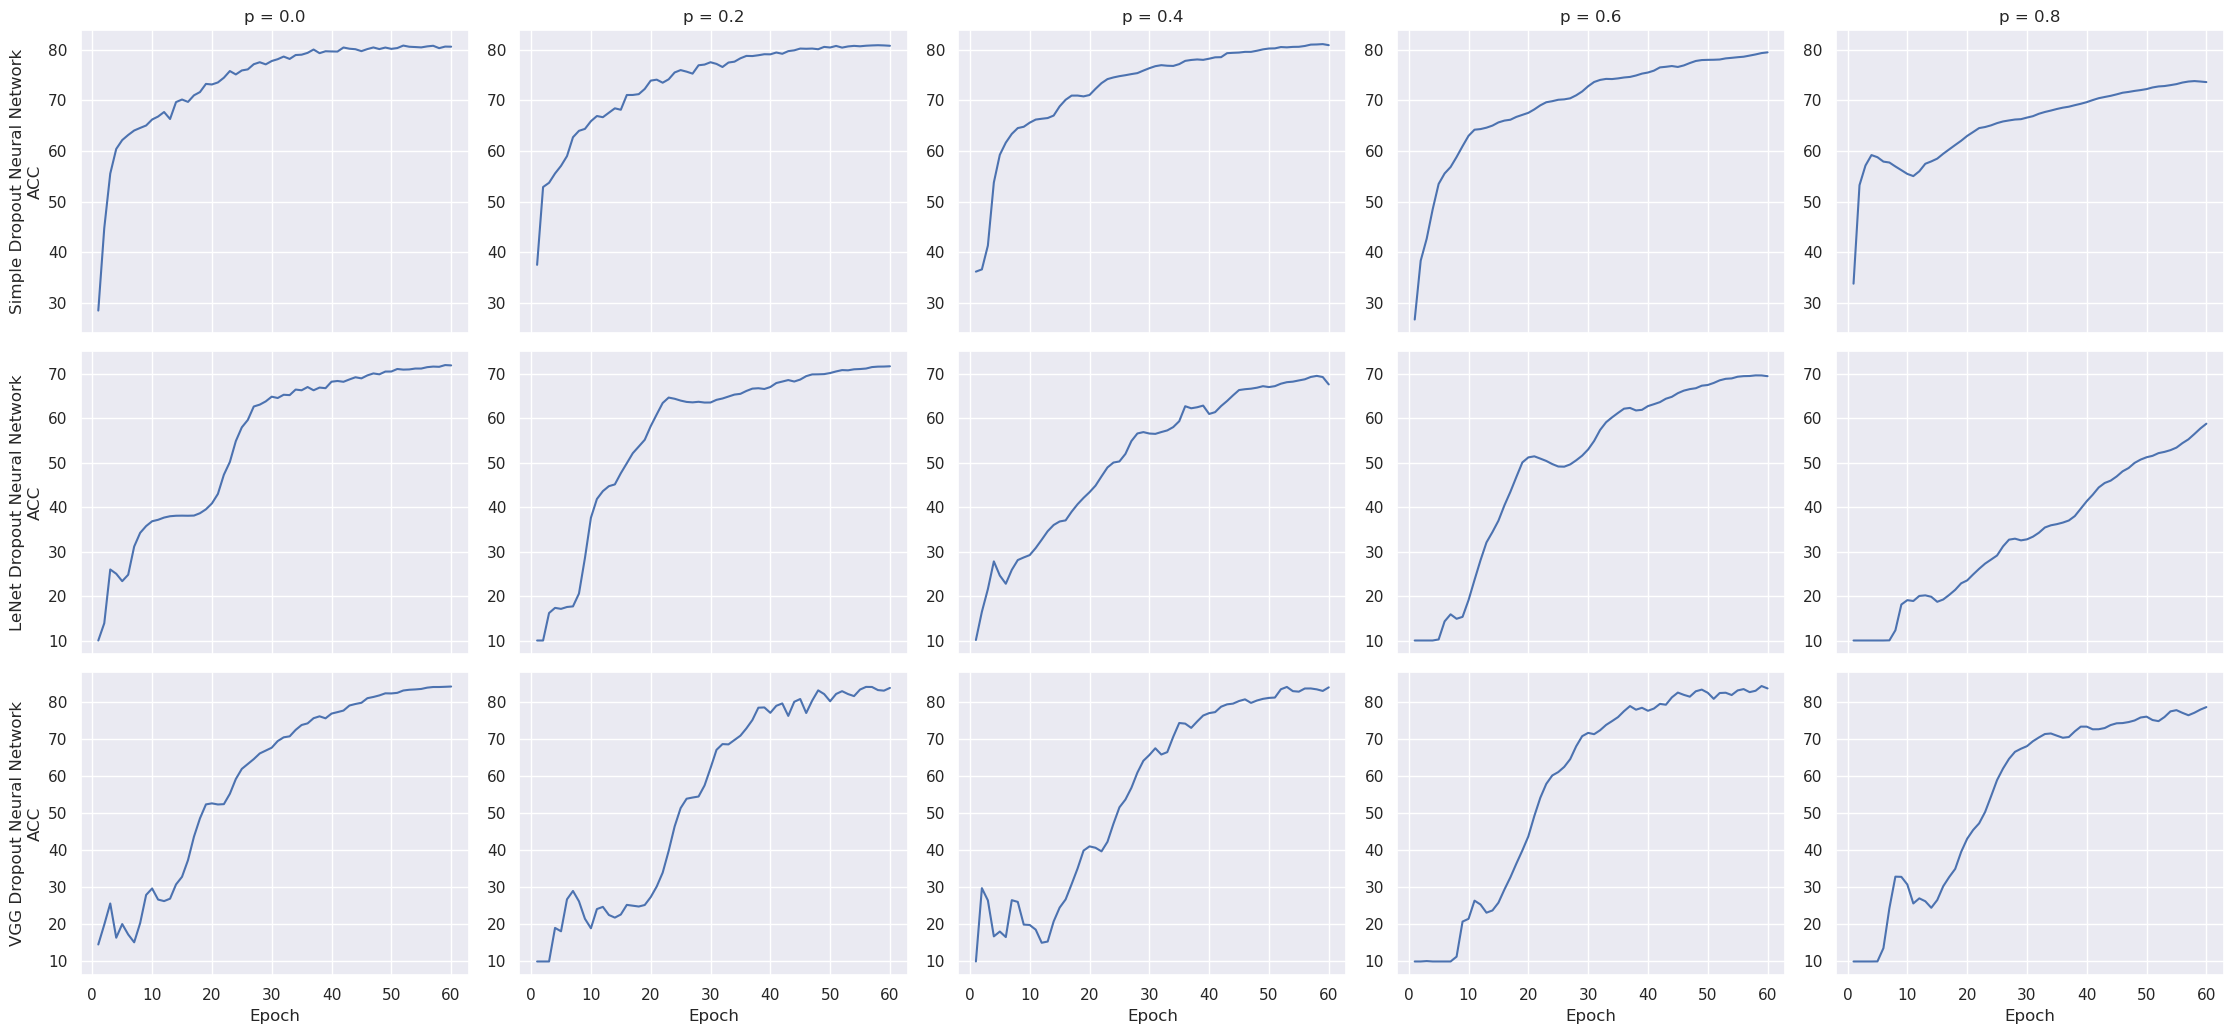

In [22]:
plot_dropout_histories(results_small, metric="acc")

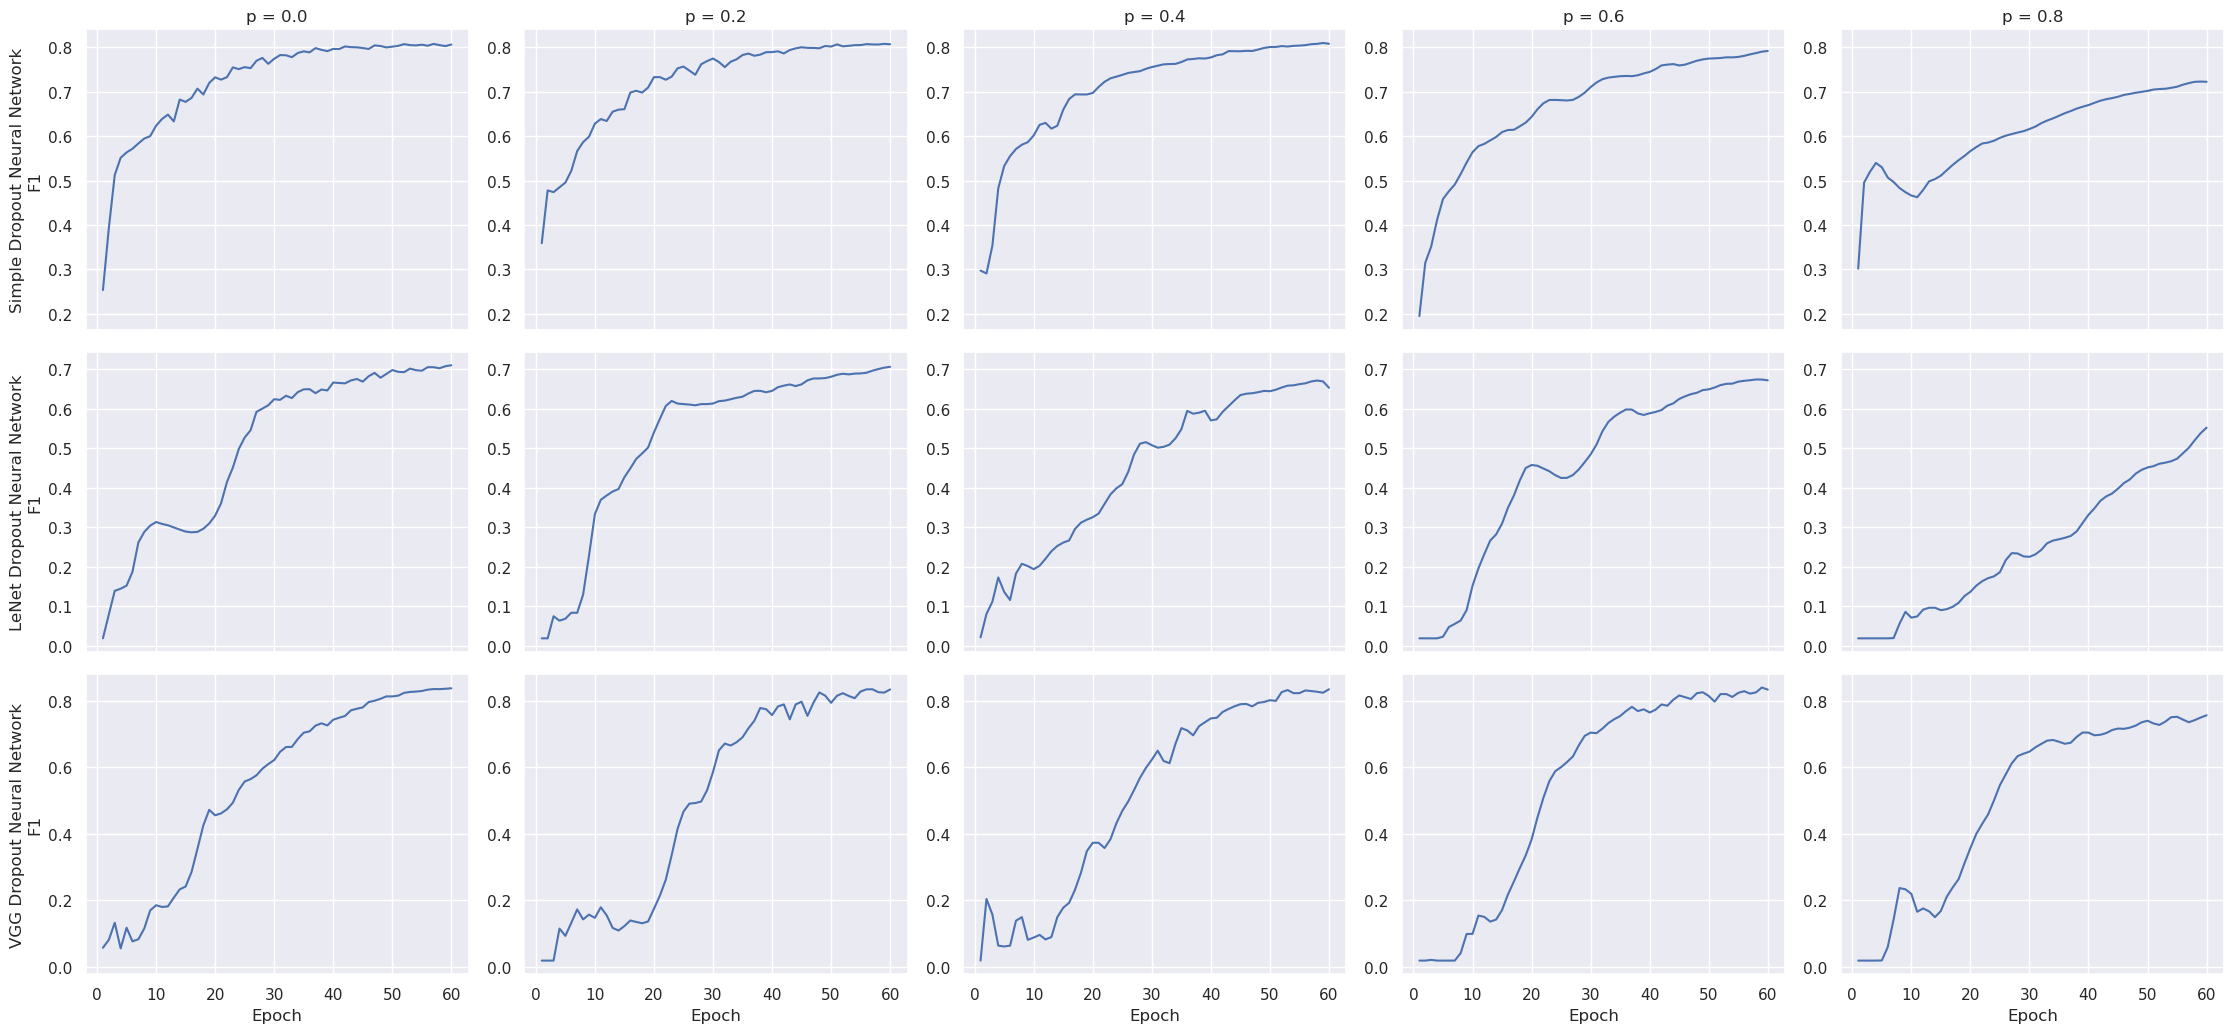

In [23]:
plot_dropout_histories(results_small, metric="f1")

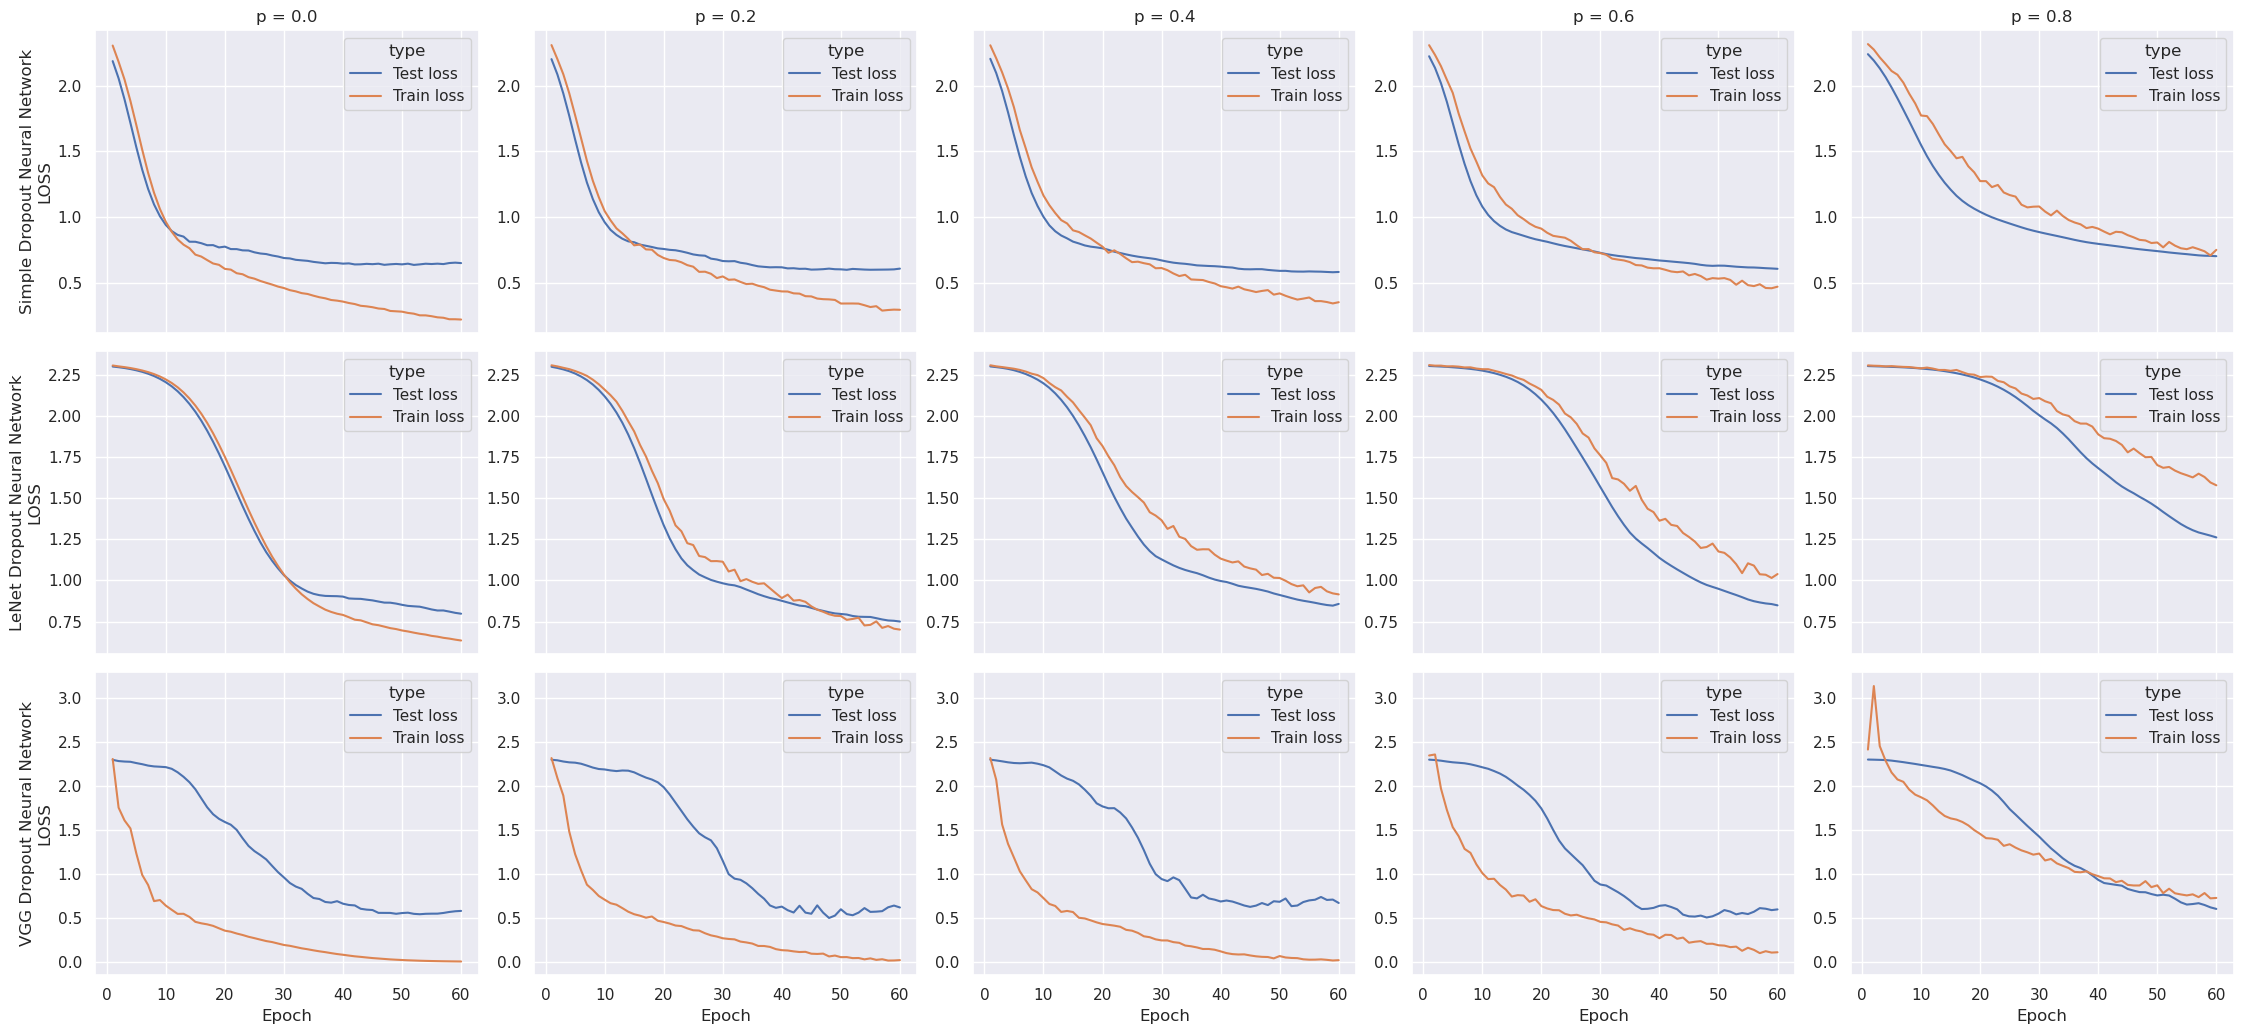

In [24]:
plot_dropout_histories(results_small, metric="loss")

## Training with Noise

In [25]:
len(train)

60000

In [26]:
# create noise
noise_level = 0.1
num_corrupted = int(len(train) * noise_level)

corrupt_indices = torch.randperm(len(train))[:num_corrupted]
train_loader.targets[corrupt_indices] = torch.randint(
    0, 10, (num_corrupted,), device=device
)

In [27]:
results = {}

for dropout_model in dropout_models:
    for p in dropout_rates:
        print(f"\nTesting Dropout p={p}")
        model = dropout_model(dropout_rate=p, dropout_mode="inverted", input_channels=1, img_size=28).to(device)
        history = train_and_validate(model, train_loader, test_loader, epochs=100, max_norm=3.0) #TODO: testar outros valores max_norm? (ex: None, 4.0)
        try:
            results[model.name][p] = history
        except:
            results[model.name] = {}
            results[model.name][p] = history


Testing Dropout p=0.0


Training model 'Simple Dropout Neural Network': 100%|██████████| 100/100 [00:20<00:00,  4.89it/s]


Finished in 20.46s

Testing Dropout p=0.2


Training model 'Simple Dropout Neural Network': 100%|██████████| 100/100 [00:21<00:00,  4.75it/s]


Finished in 21.06s

Testing Dropout p=0.4


Training model 'Simple Dropout Neural Network': 100%|██████████| 100/100 [00:20<00:00,  4.76it/s]


Finished in 20.99s

Testing Dropout p=0.6


Training model 'Simple Dropout Neural Network': 100%|██████████| 100/100 [00:21<00:00,  4.73it/s]


Finished in 21.16s

Testing Dropout p=0.8


Training model 'Simple Dropout Neural Network': 100%|██████████| 100/100 [00:22<00:00,  4.41it/s]


Finished in 22.66s

Testing Dropout p=0.0


Training model 'LeNet Dropout Neural Network': 100%|██████████| 100/100 [00:33<00:00,  3.01it/s]


Finished in 33.24s

Testing Dropout p=0.2


Training model 'LeNet Dropout Neural Network': 100%|██████████| 100/100 [00:44<00:00,  2.24it/s]


Finished in 44.55s

Testing Dropout p=0.4


Training model 'LeNet Dropout Neural Network': 100%|██████████| 100/100 [00:44<00:00,  2.25it/s]


Finished in 44.49s

Testing Dropout p=0.6


Training model 'LeNet Dropout Neural Network': 100%|██████████| 100/100 [00:45<00:00,  2.20it/s]


Finished in 45.37s

Testing Dropout p=0.8


Training model 'LeNet Dropout Neural Network': 100%|██████████| 100/100 [00:44<00:00,  2.26it/s]


Finished in 44.19s

Testing Dropout p=0.0


Training model 'VGG Dropout Neural Network': 100%|██████████| 100/100 [14:03<00:00,  8.43s/it]


Finished in 843.40s

Testing Dropout p=0.2


Training model 'VGG Dropout Neural Network': 100%|██████████| 100/100 [14:03<00:00,  8.44s/it]


Finished in 843.72s

Testing Dropout p=0.4


Training model 'VGG Dropout Neural Network': 100%|██████████| 100/100 [13:22<00:00,  8.03s/it]


Finished in 802.95s

Testing Dropout p=0.6


Training model 'VGG Dropout Neural Network': 100%|██████████| 100/100 [13:05<00:00,  7.85s/it]


Finished in 785.10s

Testing Dropout p=0.8


Training model 'VGG Dropout Neural Network': 100%|██████████| 100/100 [08:24<00:00,  5.04s/it]

Finished in 504.16s


In [28]:
summarize_metrics(results)

Model  Dropout Rate  Test Acc (%)  F1 Score  \
5    LeNet Dropout Neural Network        0.0000       89.6300    0.8952   
6    LeNet Dropout Neural Network        0.2000       90.5000    0.9045   
7    LeNet Dropout Neural Network        0.4000       89.9100    0.8979   
8    LeNet Dropout Neural Network        0.6000       89.9600    0.8983   
9    LeNet Dropout Neural Network        0.8000       87.7000    0.8725   
0   Simple Dropout Neural Network        0.0000       85.6400    0.8573   
1   Simple Dropout Neural Network        0.2000       88.6700    0.8860   
2   Simple Dropout Neural Network        0.4000       88.9200    0.8886   
3   Simple Dropout Neural Network        0.6000       88.9700    0.8889   
4   Simple Dropout Neural Network        0.8000       87.0100    0.8682   
10     VGG Dropout Neural Network        0.0000       91.0200    0.9099   
11     VGG Dropout Neural Network        0.2000       89.8000    0.8990   
12     VGG Dropout Neural Network        0.4000       88.0600    0.8801   
13     VGG Dropout Neural Network        0.6000       88.9600    0.8882   
14     VGG Dropout Neural Network        0.8000       90.3200    0.9031   

    Test Loss  
5      0.3597  
6      0.3373  
7      0.3456  
8      0.3546  
9      0.4727  
0      0.6643  
1      0.4337  
2      0.3776  
3      0.3661  
4      0.4206  
10     0.7923  
11     0.6220  
12     0.6921  
13     0.6375  
14     0.5075

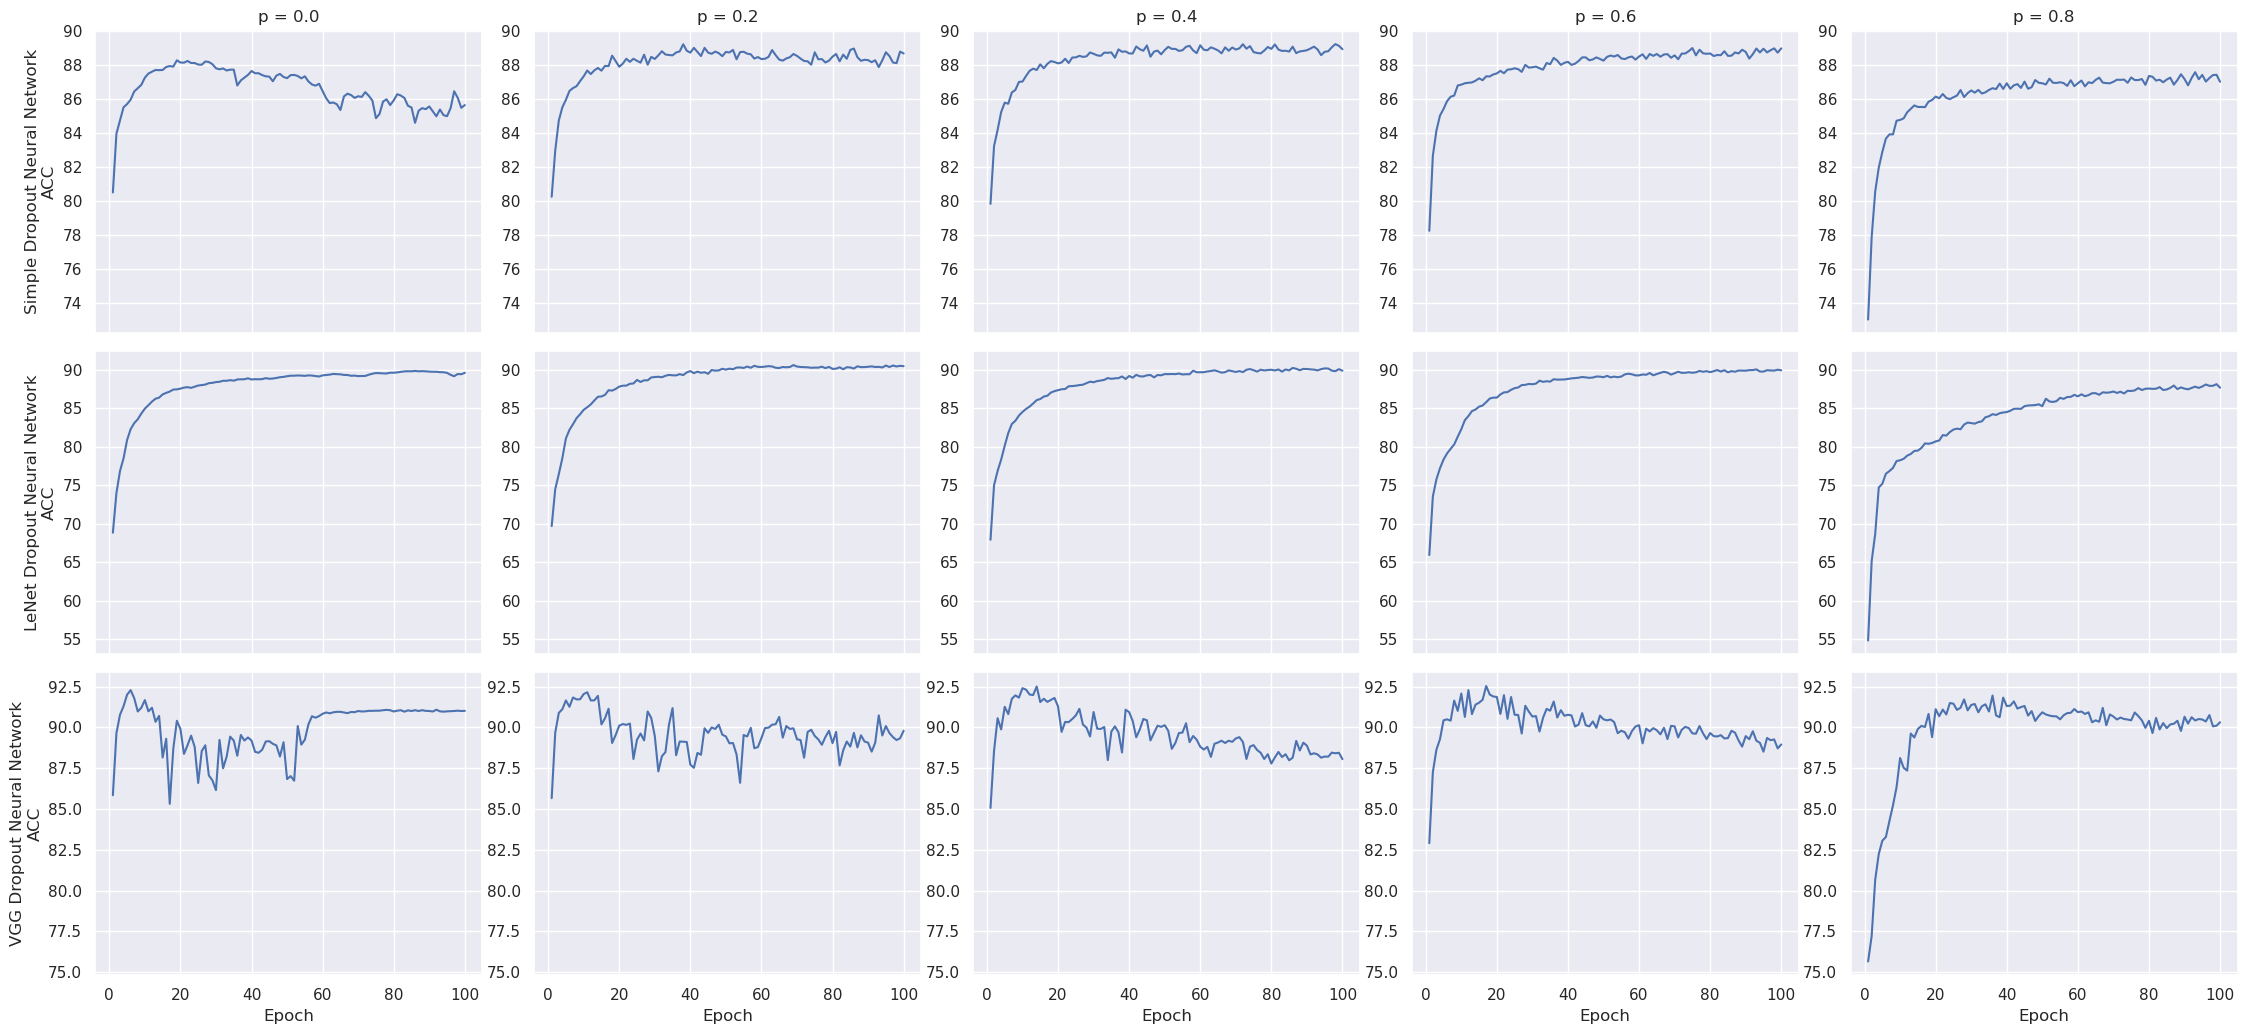

In [29]:
plot_dropout_histories(results, metric="acc")

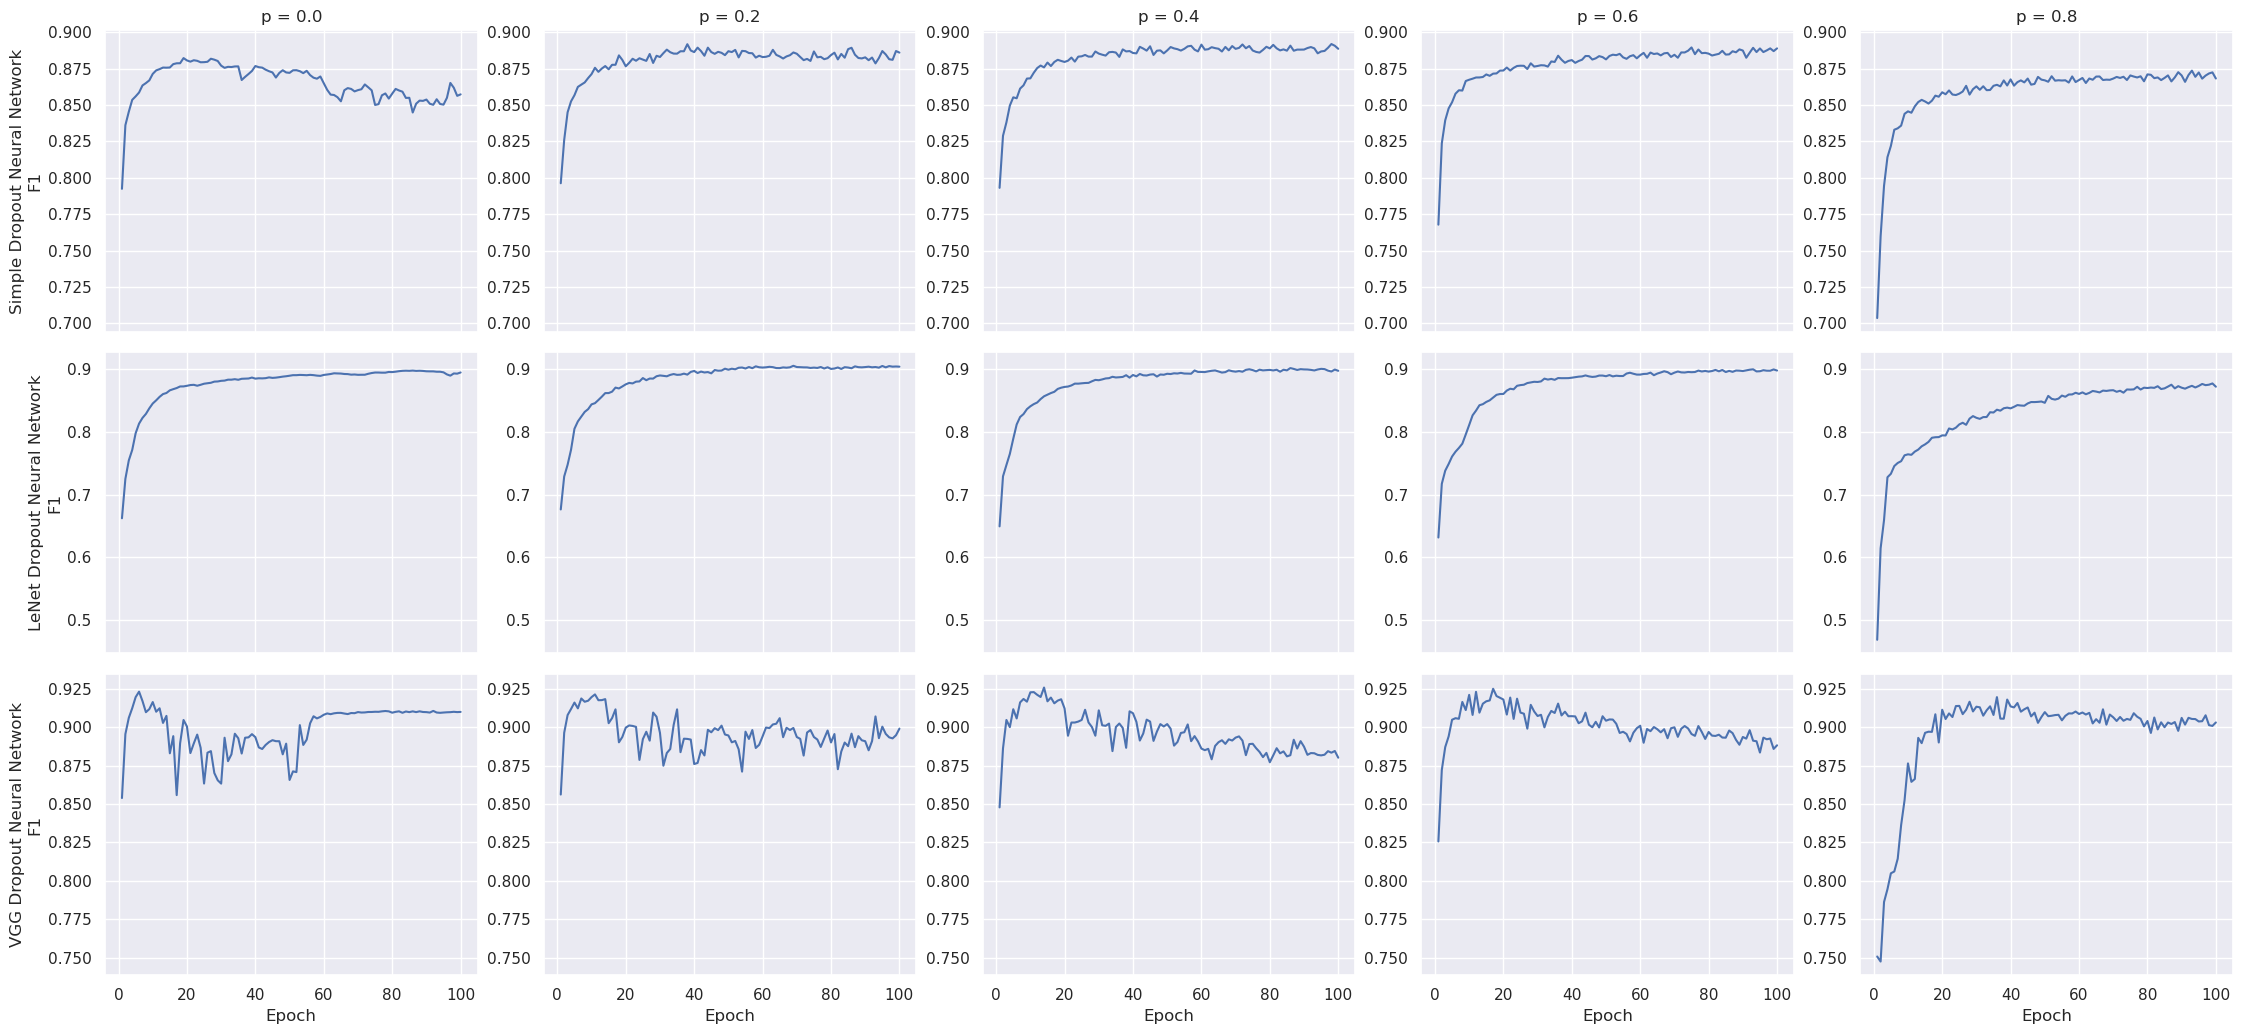

In [30]:
plot_dropout_histories(results, metric="f1")

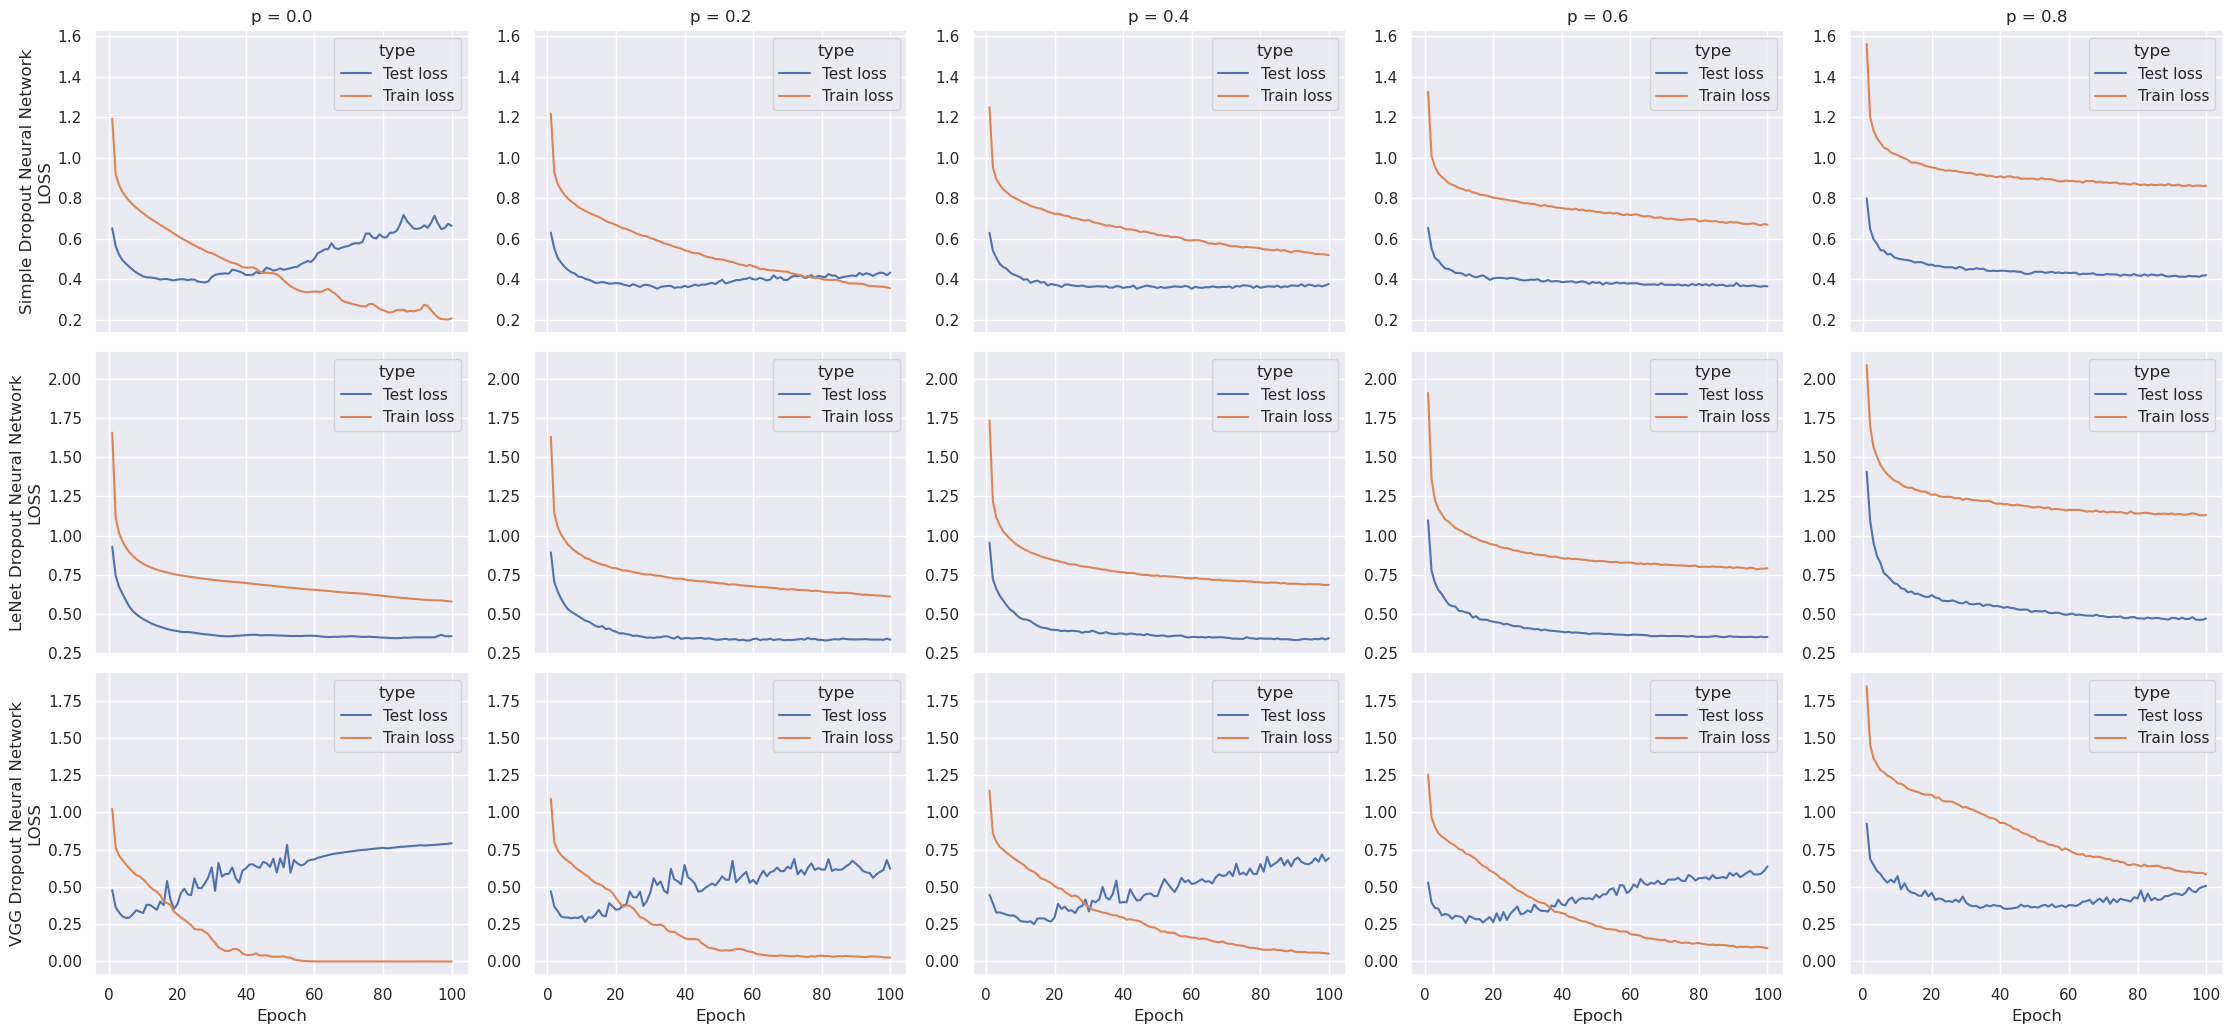

In [31]:
plot_dropout_histories(results, metric="loss")